In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
from math import pi, exp, log10, sqrt, log
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [6]:
class FirstOrderForward:
    
    # constant parameters used in computing
    _c1 =  1.211243
    _c2 = -0.08972168
    _c3 =  0.001384277
    _c4 = -0.00176566
    _c5 =  0.0001186795
    
    # model parameters
    _pmodel = None
    _vpmodel = None
    _vsmodel = None
    _c11 = None   # = c33 = λ+ 2μ
    _c13 = None   # = λ
    _c44 = None   # = μ
    _vx = None
    _vx = None
    _dt = 0
    _dx = 0
    _dz = 0
    _nt = 0
    _nx = 0
    _nz = 0
    _tmax = 0
    _xmax = 0
    _zmax = 0
    
    def __init__(self, pmodel=None, vpmodel=None, vsmodel=None, tmax=1., xmax=1000., zmax=800., nt=1000, nx=100, nz=80):
        # if not setting model parameter, using a easy model to test

        self._pmodel = pmodel
        self._vpmodel = vpmodel
        self._vsmodel = vsmodel
        # setting other parameters     
        self._tmax = tmax
        self._xmax = xmax
        self._zmax = zmax
        self._nt = nt
        self._nx = nx
        self._nz = nz
        
        # computing some parameters
        self._dt = tmax/nt
        self._dx = xmax/nx
        self._dz = zmax/nz
        
        self._c11 = self._pmodel * np.power(self._vpmodel, 2)
        self._c44 = self._pmodel * np.power(self._vsmodel, 2)
        self._c13 = self._c11 - 2 * self._c44
        
        # initialize the u
        self._vx = np.zeros((nx, nz, nt), dtype=float)
        self._vz = np.zeros((nx, nz, nt), dtype=float)

    # forward modeling operator with precion of O(4,10)
    def o4xFM(self, wavelet, wavalet_position, wavalet_direction='z'):
        # setting time array
        t_array = np.arange(0, self._tmax, self._dt)
        
        # initialize parameter used in process
        u = np.zeros((self._nx, self._nz), dtype=float)
        v = np.zeros((self._nx, self._nz), dtype=float)
        r = np.zeros((self._nx, self._nz), dtype=float)
        t = np.zeros((self._nx, self._nz), dtype=float)
        h = np.zeros((self._nx, self._nz), dtype=float)
        
        # start to compute
        for tk, tt in enumerate(t_array):
            if tk >= 1:  # the first step needs not to compute
                u = self.o4xComputeVx(u, v, r, t, h)
                v = self.o4xComputeVz(u, v, r, t, h)
                r = self.o4xComputeTauxx(u ,v, r, t, h)
                t = self.o4xComputeTauzz(u ,v, r, t, h)
                h = self.o4xComputeTauxz(u ,v, r, t, h)
                
#                 print("u times of " + str(tk))
#                 print(u[wavalet_position[1]-2:wavalet_position[1]+3,wavalet_position[0]-2:wavalet_position[0]+3])
#                 print("v times of " + str(tk))
#                 print(v[wavalet_position[1]-2:wavalet_position[1]+3,wavalet_position[0]-2:wavalet_position[0]+3])
#                 print("r times of " + str(tk))
#                 print(r[wavalet_position[1]-2:wavalet_position[1]+3,wavalet_position[0]-2:wavalet_position[0]+3])
#                 print("t times of " + str(tk))
#                 print(t[wavalet_position[1]-2:wavalet_position[1]+3,wavalet_position[0]-2:wavalet_position[0]+3])
#                 print("h times of " + str(tk))
#                 print(h[wavalet_position[1]-2:wavalet_position[1]+3,wavalet_position[0]-2:wavalet_position[0]+3])
            if tk < len(wavelet):  # source is active
                if wavalet_direction=='x':
                    u[wavalet_position[0], wavalet_position[1]] += wavelet[tk]
                else:
                    v[wavalet_position[0], wavalet_position[1]] += wavelet[tk]
                
                self._vx[:,:,tk] = u
                self._vz[:,:,tk] = v
      
    # function to oompute the velocity in x axis of the next time step
    def o4xComputeVx(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        # compute the 1st item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[5,:] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        one = self._dt / (self._dx * self._pmodel * 2) * convolve(r, kernal, mode='same') * 0.5
        
        # compute the 2nd item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[:,5] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        two = self._dt / (self._dz * self._pmodel * 2) * convolve(h, kernal, mode='same') * 0.5
        
        # compute the 3rd item
        kernal = np.zeros((5, 5), dtype=float)
        # kernal[2,:] = [-1, 3, -3, 1, 0]
        kernal[:,2] = [0, 1, -3, 3, -1]
        three = self._dt**3 * self._c11 / (24 * self._pmodel**2 * self._dx**3) * convolve(r, kernal, mode='same')
        
        # compute the 4th item
        # kernal = np.array([[-1, 2, -1],[1, -2, 1],[0, 0, 0]])
        kernal = np.array([[0, 1, -1],[0, -2, 2],[0, 1, -1]])
        four = self._dt**3 * (self._c44 + self._c11 + self._c13) \
                / (24 * self._pmodel**2 * self._dz * self._dx**2) * convolve(h, kernal, mode='same')
        
        # compute the 5th item
        # kernal = np.array([[-1, 1, 0],[2, -2, 0],[-1, 1, 0]])
        kernal = np.array([[0, 0, 0],[1, -2, 1],[-1, 2, -1]])
        five = self._dt**3 * (self._c44 + self._c13) \
                / (24 * self._pmodel**2 * self._dz**2 * self._dx) * convolve(t, kernal, mode='same')      
        
        # compute the 6th item
        # kernal = np.array([[-1, 1, 0],[2, -2, 0],[-1, 1, 0]])
        kernal = np.array([[0, 0, 0],[1, -2, 1],[-1, 2, -1]])
        six = self._dt**3 * self._c44 \
                / (24 * self._pmodel**2 * self._dz**2 * self._dx) * convolve(r, kernal, mode='same' )  
        
        # compute the 7th item
        kernal = np.zeros((5, 5), dtype=float)
        # kernal[:,2] = [-1, 3, -3, 1, 0]
        kernal[2, :] = [0, 1, -3, 3, -1]
        seven = self._dt**3 * self._c44 \
                / (24 * self._pmodel**2 * self._dz**3) * convolve(h, kernal, mode='same')
        
        # sum all
        output = u + one + two + three + four + five + six + seven
        
        return output    
    
    # function to oompute the velocity in z axis of the next time step
    def o4xComputeVz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        # compute the 1st item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[5,:] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]       
        one = self._dt / (self._dx * self._pmodel * 2) * convolve(h, kernal, mode='same') * 0.5
        
        # compute the 2nd item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[:,5] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        two = self._dt / (self._dz * self._pmodel * 2) * convolve(t, kernal, mode='same') * 0.5
        
        # compute the 3rd item
        kernal = np.zeros((5, 5), dtype=float)
        # kernal[2,:] = [0, -1, 3, -3, 1]
        kernal[:,2] = [1, -3, 3, -1, 0]
        three = self._dt**3 * self._c44 / (24 * self._pmodel**2 * self._dx**3) * convolve(h, kernal, mode='same')
        
        # compute the 4th item
        # kernal = np.array([[0, -1, 1],[0, 2, -2],[0, -1, 1]])
        kernal = np.array([[1, -2, 1],[-1, 2, -1],[0, 0, 0]])
        four = self._dt**3 * (self._c44 + self._c11 + self._c13) \
                / (24 * self._pmodel**2 * self._dx * self._dz**2) * convolve(h, kernal, mode='same')
        
        # compute the 5th item
        # kernal = np.array([[0, 0, 0],[-1, 2, -1],[1, -2, 1]])
        kernal = np.array([[1, -1, 0],[-2, 2, 0],[1, -1, 0]])
        five = self._dt**3 * (self._c44 + self._c13) \
                / (24 * self._pmodel**2 * self._dx**2 * self._dz) * convolve(r, kernal, mode='same')      
        
        # compute the 6th item
        # kernal = np.array([[0, 0, 0],[-1, 2, -1],[1, -2, 1]])
        kernal = np.array([[1, -1, 0],[-2, 2, 0],[1, -1, 0]])
        six = self._dt**3 * self._c44 \
                / (24 * self._pmodel**2 * self._dx**2 * self._dz) * convolve(t, kernal, mode='same')
        
        # compute the 7th item
        kernal = np.zeros((5, 5), dtype=float)
        # kernal[:,2] = [0, -1, 3, -3, 1]
        kernal[2,:] = [1, -3, 3, -1, 0]
        seven = self._dt**3 * self._c11 \
                / (24 * self._pmodel**2 * self._dz**3) * convolve(t, kernal, mode='same')
        
        # sum all
        output = v + one + two + three + four + five + six + seven
        
        return output

    # function to oompute the stress on xx
    def o4xComputeTauxx(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        # compute the 1st item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[5,:] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]       
        one = self._dt * self._c11 / self._dx * convolve(u, kernal, mode='same') * 0.5
        
        # compute the 2nd item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[:,5] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]       
        two = self._dt * self._c13 / self._dz * convolve(v, kernal, mode='same') * 0.5
        
        # computer the 3rd item
        kernal = np.zeros((5,5), dtype=float)
        # kernal[2,:] = [0, -1, 3, -3, 1]
        kernal[:,2] = [1, -3, 3, -1, 0]
        three = self._dt**3 * self._c11**2 / (24 * self._pmodel * self._dx**3) * convolve(u, kernal, mode='same')
        
        # computer the 4th item
        # kernal = np.array([[-1, 2, -1],[1, -2, 1],[0, 0, 0]])
        kernal = np.array([[0, 1, -1],[0, -2, 2],[0, 1, -1]])
        four = self._dt**3 * (self._c11*self._c13 + self._c11*self._c44 + self._c13*self._c44) \
                / (24 * self._pmodel * self._dx**2 * self._dz) * convolve(v, kernal, mode='same')  
        
        # computer the 5th item
        # kernal = np.array([[0, -1, 1],[0, 2, -2],[0, -1, 1]])
        kernal = np.array([[1, -2, 1],[-1, 2, -1],[0, 0, 0]])
        five = self._dt**3 * (self._c13**2 + self._c11*self._c44 + self._c13*self._c44) \
                / (24 * self._pmodel * self._dz**2 * self._dx) * convolve(u, kernal, mode='same')  

        # computer the 6th item
        kernal = np.zeros((5,5), dtype=float)
        # kernal[:,2] = [-1, 3, -3, 1, 0]
        kernal[2, :] = [0, 1, -3, 3, -1]
        six = self._dt**3 * self._c11* self._c13 / (24 * self._pmodel * self._dz**3) * convolve(v, kernal, mode='same')
        
        # sum all
        output = r + one + two + three + four + five + six
        
        return output
    
    # function to oompute the stress on zz
    def o4xComputeTauzz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        # compute the 1st item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[5,:] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]       
        one = self._dt * self._c13 / self._dx * convolve(u, kernal, mode='same') * 0.5
        
        # compute the 2nd item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[:,5] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[5, :] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]               
        two= self._dt * self._c11 / self._dz * convolve(v, kernal, mode='same') * 0.5
        
        # computer the 3rd item
        kernal = np.zeros((5,5), dtype=float)
        # kernal[2,:] = [0, -1, 3, -3, 1]
        kernal[:,2] = [1, -3, 3, -1, 0]
        three = self._dt**3 * self._c11 * self._c13 / (24 * self._pmodel * self._dx**3) * convolve(u, kernal, mode='same')
        
        # computer the 4th item
        # kernal = np.array([[-1, 2, -1],[1, -2, 1],[0, 0, 0]])
        kernal = np.array([[0, 1, -1],[0, -2, 2],[0, 1, -1]])
        four = self._dt**3 * (self._c13**2 + self._c13*self._c44 + self._c11*self._c44) \
                / (24 * self._pmodel * self._dx**2 * self._dz) * convolve(v, kernal, mode='same')  
        
        # computer the 5th item
        # kernal = np.array([[0, -1, 1],[0, 2, -2],[0, -1, 1]])
        kernal = np.array([[1, -2, 1],[-1, 2, -1],[0, 0, 0]])
        five = self._dt**3 * (self._c13 * self._c11 + self._c13 * self._c44 + self._c11 * self._c44) \
                / (24 * self._pmodel * self._dz**2 * self._dx) * convolve(u, kernal, mode='same')  

        # computer the 6th item
        kernal = np.zeros((5,5), dtype=float)
        # kernal[:,2] = [-1, 3, -3, 1, 0]
        kernal[2, :] = [0, 1, -3, 3, -1]
        six = self._dt**3 * self._c11**2 / (24 * self._pmodel * self._dz**3) * convolve(v, kernal, mode='same')
        
        # sum all
        output = t + one + two + three + four + five + six
        
        return output
    
    # function to oompute the stress on xz
    def o4xComputeTauxz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
#         print("************************")
#         print("check tauxz")
#         print("input of u")
#         print(u[73:78,73:78])
#         print("input of v")
#         print(v[73:78,73:78])
#         print("input of r")
#         print(r[73:78,73:78])
#         print("input of t")
#         print(t[73:78,73:78])
#         print("input of h")
#         print(h[73:78,73:78])
        
        # compute the 1st item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[5,:] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]       
        one = self._dt * self._c44 / self._dx * convolve(v, kernal, mode='same') * 0.5
#         print("input of one")
#         print(one[73:78,73:78])
        
        # compute the 2nd item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[:,5] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[5, :] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]       
        two = self._dt * self._c44 / self._dz * convolve(u, kernal, mode='same') * 0.5
#         print("input of two")
#         print(two[73:78,73:78])
        
        # computer the 3rd item
        kernal = np.zeros((5,5), dtype=float)
        # kernal[2,:] = [-1, 3, -3, 1, 0]
        kernal[:,2] = [0, 1, -3, 3, -1]
        three = self._dt**3 * self._c44**2 / (24 * self._pmodel * self._dx**3) * convolve(v, kernal, mode='same')
#         print("input of three")
#         print(three[73:78,73:78])
        
        # computer the 4th item
        # kernal = np.array([[0, 0, 0],[-1, 2, -1],[1, -2, 1]])
        kernal = np.array([[1, -1, 0],[-2, 2, 0],[1, -1, 0]])
        four = self._dt**3 * (self._c44**2 + self._c11*self._c44 + self._c13*self._c44) \
                / (24 * self._pmodel * self._dx**2 * self._dz) * convolve(u, kernal, mode='same')  
#         print("input of four")
#         print(four[73:78,73:78])
        
        # computer the 5th item
        # kernal = np.array([[-1 ,1, 0],[2, -2, 0],[-1, 1, 0]])
        kernal = np.array([[0,0,0],[1, -2, 1],[-1, 2, -1]])
        five = self._dt**3 * self._c44 * (self._c13 + self._c44 + self._c11) \
                / (24 * self._pmodel * self._dz**2 * self._dx) * convolve(v, kernal, mode='same')  
#         print("input of five")
#         print(five[73:78,73:78])
        
        # computer the 6th item
        kernal = np.zeros((5,5), dtype=float)
        # kernal[:,2] = [0, -1, 3, -3, 1]
        kernal[2, :] = [1, -3, 3, -1, 0]
        six = self._dt**3 * self._c44**2 / (24 * self._pmodel * self._dz**3) * convolve(u, kernal, mode='same')
#         print("input of six")
#         print(six[73:78,73:78])
        
        # sum all
        output = h + one + two + three + four + five + six
#         print("input of sum")
#         print(output[73:78,73:78]) 
        return output
    
    def DrawModel(self):
        if self._nx > self._nz:
            plt.figure(figsize=(20, 4))
        elif self._nx == self._nz:
            plt.figure(figsize=(20, 6))
        else:
            plt.figure(figsize=(20, 8))
        
        ax1 = plt.subplot(1,3,1)
        plt.imshow(self._pmodel.T, cmap=plt.cm.cool, aspect='auto')
        plt.title("density model")
        plt.colorbar(shrink=0.8)
        
        plt.subplot(1,3,2)
        plt.imshow(self._vpmodel.T, cmap=plt.cm.cool, aspect='auto')
        plt.title("P wave velocity model")
        plt.colorbar(shrink=0.8)

        plt.subplot(1,3,3)
        plt.imshow(self._vsmodel.T, cmap=plt.cm.cool, aspect='auto')
        plt.title("S wave velocitydensity model")
        plt.colorbar(shrink=0.8)
        
    def RangeInOne(self, array):
        _max = max(np.max(array), abs(np.min(array)))
        return array / _max        

    def DrawWaveField(self):
        iterations_to_show = [150, 250, 370, 500]
        fgr, axs = plt.subplots(1,len(iterations_to_show), figsize = (18,10))
        for j, ax in enumerate(axs):
            ax.imshow(self.RangeInOne(self._vx[:, :, iterations_to_show[j]].T), cmap = plt.cm.coolwarm, vmin = -1, vmax = 1, interpolation='bilinear', aspect='auto')
            ax.annotate("t = {0} ms".format(iterations_to_show[j]), xy=(0.05, 0.05), xycoords="axes fraction")
        plt.show()
        
    def DrawXWaveField(self, iterations_to_show):
        # iterations_to_show = [150, 250, 370, 500]
        fgr, axs = plt.subplots(1,len(iterations_to_show), figsize = (18,10))
        for j, ax in enumerate(axs):
            ax.imshow(self.RangeInOne(self._vx[:, :, iterations_to_show[j]].T), cmap = plt.cm.coolwarm, vmin = -1, vmax = 1, interpolation='bilinear')
            ax.annotate("t = {0} ms".format(iterations_to_show[j]), xy=(0.05, 0.05), xycoords="axes fraction")
        plt.show()
        
    def DrawZWaveField(self, iterations_to_show):
        # iterations_to_show = [150, 250, 370, 500]
        fgr, axs = plt.subplots(1,len(iterations_to_show), figsize = (18,10))
        for j, ax in enumerate(axs):
            ax.imshow(self.RangeInOne(self._vz[:, :, iterations_to_show[j]].T), cmap = plt.cm.coolwarm, vmin = -1, vmax = 1, interpolation='bilinear')
            ax.annotate("t = {0} ms".format(iterations_to_show[j]), xy=(0.05, 0.05), xycoords="axes fraction")
        plt.show()
        
    
    def o24FM(self, wavelet, wavalet_position, wavalet_direction='z'):    
        # setting time array
        t_array = np.arange(0, self._tmax, self._dt)
        
        # initialize parameter used in process
        u = np.zeros((self._nx, self._nz), dtype=float)
        v = np.zeros((self._nx, self._nz), dtype=float)
        r = np.zeros((self._nx, self._nz), dtype=float)
        t = np.zeros((self._nx, self._nz), dtype=float)
        h = np.zeros((self._nx, self._nz), dtype=float)
        for tk, tt in enumerate(t_array):
            if tk >= 1:  # the first step needs not to compute
                u = self.o24ComputeVx(u, v, r, t, h)
                v = self.o24ComputeVz(u, v, r, t, h)
                r = self.o24ComputeTauxx(u ,v, r, t, h)
                t = self.o24ComputeTauzz(u ,v, r, t, h)
                h = self.o24ComputeTauxz(u ,v, r, t, h)
                
                print("u times of " + str(tk))
                print(u[wavalet_position[1]-2:wavalet_position[1]+3,wavalet_position[0]-2:wavalet_position[0]+3])
                print(u[0:5,0:5])
                print("v times of " + str(tk))
                print(v[wavalet_position[1]-2:wavalet_position[1]+3,wavalet_position[0]-2:wavalet_position[0]+3])
                print(v[0:5,0:5])
                print("r times of " + str(tk))
                print(r[wavalet_position[1]-2:wavalet_position[1]+3,wavalet_position[0]-2:wavalet_position[0]+3])
                print(r[0:5,0:5])
                print("t times of " + str(tk))
                print(t[wavalet_position[1]-2:wavalet_position[1]+3,wavalet_position[0]-2:wavalet_position[0]+3])
                print(t[0:5,0:5])
                print("h times of " + str(tk))
                print(h[wavalet_position[1]-2:wavalet_position[1]+3,wavalet_position[0]-2:wavalet_position[0]+3])
                print(h[0:5,0:5])
                
                if tk < len(wavelet):  # source is active
                    if wavalet_direction=='x':
                        u[wavalet_position[1], wavalet_position[0]] += wavelet[tk]
                    else:
                        v[wavalet_position[1], wavalet_position[0]] += wavelet[tk]

            self._vx[:,:,tk] = u
            self._vz[:,:,tk] = v
            
    def o24ComputeVx(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        kernal = np.array([[0,0,0],[0,1,0],[0,-1,0]])
        one = self._dt / (self._pmodel * self._dx) * convolve(r, kernal, mode='same', method='direct')
        
        kernal = np.array([[0,0,0],[0,1,-1],[0,0,0]])
        two = self._dt / (self._pmodel * self._dz) * convolve(h, kernal, mode='same', method='direct')
        
        output = u + one + two
        
        return output
        
    def o24ComputeVz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.array([[0,1,0],[0,-1,0],[0,0,0]])
        one = self._dt / (self._pmodel * self._dx) * convolve(h, kernal, mode='same', method='direct')
        
        kernal = np.array([[0,0,0],[1,-1,0],[0,0,0]])
        two = self._dt / (self._pmodel * self._dz) * convolve(t, kernal, mode='same', method='direct')
        
        output = v + one + two
               
        return output

    def o24ComputeTauxx(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.array([[0,1,0],[0,-1,0],[0,0,0]])
        one = (self._dt * self._c11) / (self._dx) * convolve(u, kernal, mode='same', method='direct')
        
        kernal = np.array([[0,0,0],[0,1,-1],[0,0,0]])
        two = (self._dt * self._c13) / (self._dz) * convolve(v, kernal, mode='same', method='direct')
        
        output = r + one + two
        
        return output

        
    def o24ComputeTauzz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.array([[0,0,0],[0,1,-1],[0,0,0]])
        one = (self._dt * self._c11) / (self._dz) * convolve(v, kernal, mode='same', method='direct')
        
        kernal = np.array([[0,1,0],[0,-1,0],[0,0,0]])
        two = (self._dt * self._c13) / (self._dx) * convolve(u, kernal, mode='same', method='direct')
        
        output = t + one + two     
            
        return output

    def o24ComputeTauxz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.array([[0,0,0],[1,-1,0],[0,0,0]])
        one = (self._dt * self._c44) / (self._dz) * convolve(u, kernal, mode='same', method='direct')
        
        kernal = np.array([[0,0,0],[0,1,0],[0,-1,0]])
        two = (self._dt * self._c44) / (self._dx) * convolve(v, kernal, mode='same', method='direct')
        
        output = h + one + two

        return output

In [7]:
class FristOlderForward_PML(FirstOlderForward):
    # extra parameters
    _kai_x = None
    _kai_z = None
    _sigma_x = None
    _sigma_z = None
    _alpha_x = None
    _alpha_z = None
    _pml_x = 0
    _pml_z = 0
    def __init__(self, pmodel, vpmodel, vsmodel, tmax, xmax, zmax, nt, nx, nz, kai_x, kai_z, sigma_x, sigma_z, alpha_x, alpha_z):
        
        self._pmodel = pmodel
        self._vpmodel = vpmodel
        self._vsmodel = vsmodel
        # setting other parameters     
        self._tmax = tmax
        self._xmax = xmax
        self._zmax = zmax
        self._nt = nt
        self._nx = nx
        self._nz = nz
        
        # computing some parameters
        self._dt = tmax/nt
        self._dx = xmax/nx
        self._dz = zmax/nz
        
        self._c11 = self._pmodel * np.power(self._vpmodel, 2)
        self._c44 = self._pmodel * np.power(self._vsmodel, 2)
        self._c13 = self._c11 - 2 * self._c44
        
        # initialize the amplitude u
        self._vx = np.zeros((nx, nz, nt), dtype=float)
        self._vz = np.zeros((nx, nz, nt), dtype=float)
        
        # initial kai sigma alpha
        self._kai_x = kai_x
        self._kai_z = kai_z
        self._sigma_x = sigma_x
        self._sigma_z = sigma_z
        self._alpha_x = alpha_x
        self._alpha_z = alpha_z
        
    def o24FM(self, wavelet, wavalet_position, wavalet_direction='z'):
        # a o(2,4) forward modeling
        t_array = np.arange(0, self._tmax, self._dt)
        
        # set auxiliary parameters
        u = np.zeros((nx,nz), dtype=float)
        v = np.zeros((nx,nz), dtype=float)
        r = np.zeros((nx,nz), dtype=float)
        t = np.zeros((nx,nz), dtype=float)
        h = np.zeros((nx,nz), dtype=float)
        
        omega_xx = np.zeros((nx,nz), dtype=float)
        omega_xz = np.zeros((nx,nz), dtype=float)
        omega_zx = np.zeros((nx,nz), dtype=float)
        omega_zz = np.zeros((nx,nz), dtype=float)
        phi_xx = np.zeros((nx,nz), dtype=float)
        phi_zz = np.zeros((nx,nz), dtype=float)
        phi_zx = np.zeros((nx,nz), dtype=float)
        phi_xz = np.zeros((nx,nz), dtype=float)

        for tk, tt in enumerate(t_array):
            if tk >= 1:  # the first step needs not to compute

                u = self.o24ComputeVx(u, v, r, t, h)
                v = self.o24ComputeVz(u, v, r, t, h)
                print("====after compute====")
                # print(u[107:113,8:14])
                print(u[wavalet_position[1]-3:wavalet_position[1]+3,wavalet_position[0]-3:wavalet_position[0]+3])       
                # update pml correction
                u -= self.o24Correction_u(u, v, r ,t ,h, omega_xx, omega_xz)
                v -= self.o24Correction_v(u, v, r, t, h, omega_zx, omega_zz)
                print("====after min=====")
                print(u[107:113,8:14])
                # update omega
                omega_xx = self.o24Update_Omega_xx(omega_xx, r)
                omega_xz = self.o24Update_Omega_xz(omega_xz, h)
                omega_zx = self.o24Update_Omega_zx(omega_zx, h)
                omega_zz = self.o24Update_Omega_zz(omega_zz, t)
                
                r = self.o24ComputeTauxx(u ,v, r, t, h)
                t = self.o24ComputeTauzz(u ,v, r, t, h)
                h = self.o24ComputeTauxz(u ,v, r, t, h)
                # update pml correction
                r -= self.o24Correction_r(u, v, r, t, h, phi_xx, phi_zz)
                t -= self.o24Correction_t(u, v, r, t, h, phi_xx, phi_zz)
                h -= self.o24Correction_h(u, v, r, t, h, phi_zx, phi_xz)
                # update phi
                phi_xx = self.o24Update_Phi_xx(phi_xx, u)
                phi_zz = self.o24Update_Phi_zz(phi_zz, v)
                phi_zx = self.o24Update_Phi_zx(phi_zx, v)
                phi_xz = self.o24Update_Phi_xz(phi_xz, u)
                
                if tk < len(wavelet):  # source is active
                    if wavalet_direction=='x':
                        u[wavalet_position[1], wavalet_position[0]] += wavelet[tk]
                    else:
                        v[wavalet_position[1], wavalet_position[0]] += wavelet[tk]
                    
                print("====after add source====")
                print(u[wavalet_position[1]-3:wavalet_position[1]+3,wavalet_position[0]-3:wavalet_position[0]+3])
                # print(u[wavalet_position[1], wavalet_position[0]])
                
            self._vx[:,:,tk] = u
            self._vz[:,:,tk] = v
            
    def o24Correction_u(self, u, v, r, t, h, omega_xx, omega_xz):
        kernal_1 = np.array([[0, 0, 0],[0, 1, 0],[0, -1, 0]])
        kernal_2 = np.array([[0, 0, 0],[0, 1, -1],[0, 0, 0]])
        one = (1 - 1 / self._kai_x) * convolve(r, kernal_1, mode='same')
        two = (1 - 1 / self._kai_z) * convolve(h, kernal_2, mode='same')
        return u + self._dt / self._pmodel * (one + two + omega_xx + omega_xz)
    
    def o24Correction_v(self, u, v, r, t, h, omega_zx, omega_zz):
        kernal_1 = np.array([[0, 1, 0], [0, -1, 0], [0, 0, 0]])
        kernal_2 = np.array([[0, 0, 0], [1, -1, 0], [0, 0, 0]])
        one = (1 - 1 / self._kai_x) * convolve(h, kernal_1, mode='same')
        two = (1 - 1 / self._kai_z) * convolve(t, kernal_2, mode='same')
        return v + self._dt / self._pmodel *(one + two + omega_zx + omega_zz)
    
    def o24Correction_r(self, u, v, r, t, h, phi_xx, phi_zz):
        kernal_1 = np.array([[0,1,0],[0,-1,0],[0,0,0]])
        kernal_2 = np.array([[0,0,0],[0,1,-1],[0,0,0]])
        one = self._c11 * (phi_xx + (1 - 1 / self._kai_x) * convolve(u, kernal_1, mode='same'))
        two = self._c13 * (phi_zz + (1 - 1 / self._kai_z) * convolve(v, kernal_2, mode='same'))
        return r + self._dt * (one + two)
    
    def o24Correction_t(self, u, v, r, t, h, phi_xx, phi_zz):
        kernal_1 = np.array([[0,1,0],[0,-1,0],[0,0,0]])
        kernal_2 = np.array([[0,0,0],[0,1,-1],[0,0,0]])
        one = self._c13 * (phi_xx + (1 - 1 / self._kai_x) * convolve(u, kernal_1, mode='same'))
        two = self._c11 * (phi_zz + (1 - 1 / self._kai_z) * convolve(v, kernal_2, mode='same'))
        return t + self._dt * (one + two)
    
    def o24Correction_h(self, u, v, r, t, h, phi_zx, phi_xz):
        kernal_1 = np.array([[0,0,0],[0,1,0],[0,-1,0]])
        kernal_2 = np.array([[0,0,0],[1,-1,0],[0,0,0]])
        one = self._c44 * (phi_zx + (1 - 1 / self._kai_x) * convolve(v, kernal_1, mode='same'))
        two = self._c44 * (phi_xz + (1 - 1 / self._kai_z) * convolve(u, kernal_2, mode='same'))
        return h + self._dt * (one + two)
    
    def o24Update_Omega_xx(self, omega_xx, r):
        epsilon = 1e-10  # used for avoiding to devide zero
        # c_x = 1 - 1 / self._kai_x
        b_x = np.exp(-(self._alpha_x + self._sigma_x / self._kai_x) * dt)
        a_x = (1 - b_x) * self._sigma_x / ((self._kai_x * (self._kai_x * self._alpha_x + self._sigma_x)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_x * omega_xx + a_x * convolve(r, kernal, mode='same') * 0.5
    
    def o24Update_Omega_xz(self, omega_xz, h):
        epsilon = 1e-10
        b_z = np.exp(-(self._alpha_z + self._sigma_z / self._kai_z) * dt)
        a_z = (1 - b_z) * self._sigma_z / ((self._kai_z * (self._kai_z * self._alpha_z + self._sigma_z)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_z * omega_xz + a_z * convolve(h, kernal, mode='same') * 0.5
    
    def o24Update_Omega_zx(self, omega_zx, h):
        epsilon = 1e-10  # used for avoiding to devide zero
        # c_x = 1 - 1 / self._kai_x
        b_x = np.exp(-(self._alpha_x + self._sigma_x / self._kai_x) * dt)
        a_x = (1 - b_x) * self._sigma_x / ((self._kai_x * (self._kai_x * self._alpha_x + self._sigma_x)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_x * omega_zx + a_x * convolve(h, kernal, mode='same') * 0.5

    def o24Update_Omega_zz(self, omega_zz, t):
        epsilon = 1e-10
        b_z = np.exp(-(self._alpha_z + self._sigma_z / self._kai_z) * dt)
        a_z = (1 - b_z) * self._sigma_z / ((self._kai_z * (self._kai_z * self._alpha_z + self._sigma_z)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_z * omega_zz + a_z * convolve(t, kernal, mode='same') * 0.5
    
    def o24Update_Phi_xx(self, phi_xx, u):
        epsilon = 1e-10  # used for avoiding to devide zero
        # c_x = 1 - 1 / self._kai_x
        b_x = np.exp(-(self._alpha_x + self._sigma_x / self._kai_x) * dt)
        a_x = (1 - b_x) * self._sigma_x / ((self._kai_x * (self._kai_x * self._alpha_x + self._sigma_x)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_x * phi_xx + a_x * convolve(u, kernal, mode='same') * 0.5
 
    def o24Update_Phi_zz(self, phi_zz, v):
        epsilon = 1e-10
        b_z = np.exp(-(self._alpha_z + self._sigma_z / self._kai_z) * dt)
        a_z = (1 - b_z) * self._sigma_z / ((self._kai_z * (self._kai_z * self._alpha_z + self._sigma_z)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_z * phi_zz + a_z * convolve(v, kernal, mode='same') * 0.5
    
    def o24Update_Phi_zx(self, phi_zx, v):
        epsilon = 1e-10  # used for avoiding to devide zero
        # c_x = 1 - 1 / self._kai_x
        b_x = np.exp(-(self._alpha_x + self._sigma_x / self._kai_x) * dt)
        a_x = (1 - b_x) * self._sigma_x / ((self._kai_x * (self._kai_x * self._alpha_x + self._sigma_x)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_x * phi_zx + a_x * convolve(v, kernal, mode='same') * 0.5
    
    def o24Update_Phi_xz(self, phi_xz, u):
        epsilon = 1e-10
        b_z = np.exp(-(self._alpha_z + self._sigma_z / self._kai_z) * dt)
        a_z = (1 - b_z) * self._sigma_z / ((self._kai_z * (self._kai_z * self._alpha_z + self._sigma_z)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_z * phi_xz + a_z * convolve(u, kernal, mode='same') * 0.5
    
    # a easy version of setting auxiliary parameters 
    def Cal_Auxiliary_Para(vsmodel, nx, nz, xmax, zmax, pml_x, pml_z):
        kai_x = np.zeros((nx, nz), dtype=float)
        kai_z = np.zeros((nx, nz), dtype=float)
        sigma_x = np.zeros((nx, nz), dtype=float)
        sigma_z = np.zeros((nx, nz), dtype=float)
        alpha_x = np.zeros((nx, nz), dtype=float)
        alpha_z = np.zeros((nx, nz), dtype=float)
        # sigma_max = -np.max(vsmodel) * 3 * log10(0.00001) / (2 * sqrt((xmax / nx * pml_x)**2 + (zmax / nz * pml_z)**2))
        sigma_max = 1200
        alpha_max = 150
        kai_max = 2
        ratio = np.ones((nx, nz), dtype=float)
        for tx in range(nx):
            for tz in range(nz):
                if tx < pml_x and tz < pml_z:  # locating the left top block
                    ratio[tx, tz] = sqrt(((tx - pml_x)**2 + (tz - pml_z)**2) / (pml_x**2 + pml_z**2))

                elif tx < pml_x and tz > nz - pml_z - 1: # locating the right top block
                    ratio[tx, tz] = sqrt(((tx - pml_x)**2 + (tz + pml_z - nz + 1)**2) / (pml_x**2 + pml_z**2))

                elif tx < pml_x:  # middle top block
                    ratio[tx, tz] = 1 / sqrt(pml_x**2 + pml_z**2) * (pml_x - tx)

                elif tx > nx - pml_x - 1 and tz < pml_z:  # left bottom block
                    ratio[tx, tz] = sqrt(((tx + pml_x - nx + 1)**2 + (tz - pml_z)**2) / (pml_x**2 + pml_z**2))

                elif tx > nx - pml_x - 1 and tz > nz - pml_z - 1: # the right bottom block
                    ratio[tx, tz] = sqrt(((tx + pml_x - nx + 1)**2 + (tz + pml_z - nz + 1)**2) / (pml_x**2 + pml_z**2))

                elif tz < pml_z: # the left middle block
                    ratio[tx, tz] = 1 / sqrt(pml_x**2 + pml_z**2) * (pml_z - tz)

                elif tz > nz - pml_z - 1: # the right middle block
                    ratio[tx, tz] = 1 / sqrt(pml_x**2 + pml_z**2) * (pml_z + tz - nz + 1)

                elif tx > nx - pml_x - 1: # the bottom middle block
                    ratio[tx, tz] = 1 / sqrt(pml_x**2 + pml_z**2) * (pml_x + tx - nx + 1)

                else:
                        ratio[tx, tz] = 0
        
        ratio = np.power(ratio, 2)
        
        sigma_x = sigma_max * ratio
        sigma_z = sigma_max * ratio
        
        alpha_x = alpha_max * ratio
        alpha_z = alpha_max * ratio
        
        kai_x = 1 + (kai_max - 1) * ratio
        kai_z = 1 + (kai_max - 1) * ratio

        return kai_x, kai_z, sigma_x, sigma_z, alpha_x, alpha_z

NameError: name 'FirstOlderForward' is not defined

In [8]:
# a test model
xmax = 1500
zmax = 1500
nx = 150
nz = 150
tmax = 0.5
nt = 500
f_m = 30

source_position = [75, 75]
source_direction = 'z'

pmodel = 3000 * np.ones((nx, nz), dtype=float)
vpmodel = 3000 * np.ones((nx, nz), dtype=float)
vsmodel = 1800 * np.ones((nx, nz), dtype=float)

test = FirstOrderForward(pmodel, vpmodel, vsmodel, tmax, xmax, zmax, nt, nx, nz)

# 30Hz ricker wavelet
# f(t)=(1-2*pi^2*f_m^2*t^2)e^(-pi^2*f_m^2*t^2)
source_array = np.zeros(40)
for tk , t in enumerate(np.arange(0, 0.04, 0.001)):
    #print(t,tk)
    source_array[tk] = \
            ((-4 * pi**2 * f_m**2 * t) + (2 * pi**2 * f_m**2 * t**2 - 1) * (pi**2 * f_m**2 * 2 * t)) * exp(-pi**2 * f_m**2 * t**2)

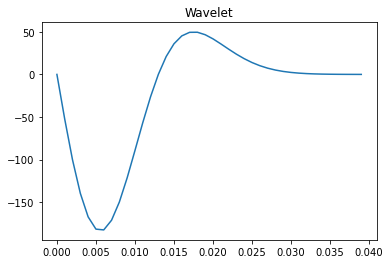

In [9]:
# draw wavelat
plt.plot(np.arange(0, 0.04, 0.001), source_array)
plt.title('Wavelet')
plt.show()

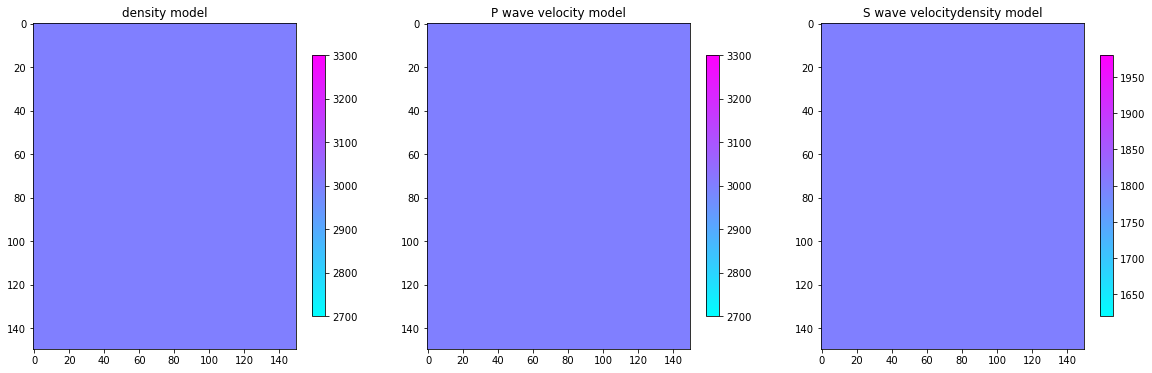

In [10]:
# draw model
test.DrawModel()

In [27]:
test.o24FM(wavelet=source_array, wavalet_position=source_position, wavalet_direction='x')

u times of 1
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
v times of 1
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
r times of 1
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
t times of 1
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
h times of 1
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
u times of 2
[[  0.      

u times of 8
[[  -0.46192622   -6.90265224  -37.90912163   -6.90265224   -0.46192622]
 [  -3.33882296  -38.86409445 -177.73301238  -38.86409445   -3.33882296]
 [  -1.57073462  -54.24477125 -244.97245049  -54.24477125   -1.57073462]
 [  -3.33882296  -38.86409445 -177.73301238  -38.86409445   -3.33882296]
 [  -0.46192622   -6.90265224  -37.90912163   -6.90265224   -0.46192622]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
v times of 8
[[-6.22325526e+00 -2.68593837e+01  2.68593837e+01  6.22325526e+00
   4.49057347e-01]
 [-2.68593837e+01 -6.71100477e+01  6.71100477e+01  2.68593837e+01
   2.96750722e+00]
 [ 2.68593837e+01  6.71100477e+01 -6.71100477e+01 -2.68593837e+01
  -2.96750722e+00]
 [ 6.22325526e+00  2.68593837e+01 -2.68593837e+01 -6.22325526e+00
  -4.49057347e-01]
 [ 4.49057347e-01  2.96750722e+00 -2.96750722e+00 -4.49057347e-01
  -1.99796577e-02]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


u times of 14
[[ -34.6515027   -87.68706755  -93.91289458  -87.68706755  -34.6515027 ]
 [ -25.18059975  -72.96182126   43.04464946  -72.96182126  -25.18059975]
 [ -24.12652112 -106.48337355  305.02198531 -106.48337355  -24.12652112]
 [ -25.18059975  -72.96182126   43.04464946  -72.96182126  -25.18059975]
 [ -34.6515027   -87.68706755  -93.91289458  -87.68706755  -34.6515027 ]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
v times of 14
[[ -54.62987789   19.94256805  -19.94256805   54.62987789   34.57073397]
 [  19.94256805  101.76629698 -101.76629698  -19.94256805   19.53081426]
 [ -19.94256805 -101.76629698  101.76629698   19.94256805  -19.53081426]
 [  54.62987789  -19.94256805   19.94256805  -54.62987789  -34.57073397]
 [  34.57073397   19.53081426  -19.53081426  -34.57073397  -13.10779777]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
r times of 14
[[-1.94706796e+08 -5.51778305e+08 -9.5667704

u times of 21
[[-11.3976466   17.65484543 114.8494415   17.65484543 -11.3976466 ]
 [-81.68017063  56.55855076 130.14457759  56.55855076 -81.68017063]
 [-60.41091087 150.31705087   6.46487645 150.31705087 -60.41091087]
 [-81.68017063  56.55855076 130.14457759  56.55855076 -81.68017063]
 [-11.3976466   17.65484543 114.8494415   17.65484543 -11.3976466 ]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
v times of 21
[[ 91.55200387  20.77433643 -20.77433643 -91.55200387 -34.56497952]
 [ 20.77433643 -53.93813394  53.93813394 -20.77433643 -28.6179918 ]
 [-20.77433643  53.93813394 -53.93813394  20.77433643  28.6179918 ]
 [-91.55200387 -20.77433643  20.77433643  91.55200387  34.56497952]
 [-34.56497952 -28.6179918   28.6179918   34.56497952 -21.99012342]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
r times of 21
[[-1.56409205e+08 -9.60556931e+07  1.02145357e+09 -9.60556931e+07
  -1.56409205e+08]
 [-3.2237

   3.18956646e+08]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
t times of 27
[[ 2.32362724e+08 -5.17068638e+08  1.36693391e+08 -5.17068638e+08
   2.32362724e+08]
 [-2.02977955e+08 -4.72420754e+07  1.94362683e+08 -4.72420754e+07
  -2.02977955e+08]
 [ 2.02977955e+08  4.72420754e+07 -1.94362683e+08  4.72420754e+07
   2.02977955e+08]
 [-2.32362724e+08  5.17068638e+08 -1.36693391e+08  5.17068638e+08
  -2.32362724e+08]
 [-3.94577701e+08  1.13367873e+08  2.86378288e+08  1.13367873e+08
  -3.94577701e+08]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
h times of 27
[[ 3.76789984e+08  5.85448216e+07 -5.85448216e+07 -3.76789984e+08
   5.72209322e+07]
 [ 3.66881122e+08 -1.90451877e+08  1.90451877e+08 -3.66881122e+08
   1.85417559e+08]
 [ 6.15910573e+08 -1.87229269e+08  1.87229269e+08 -6.15910573e+08
   1.38464801e+08]
 [ 3.66881122e+08 -1.90451877e+08  1.90451877e+08 -3.66881122e+08
   1.85417559e+08]
 [ 3

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
r times of 33
[[ 4.01650543e+08 -2.86480347e+08 -5.26941404e+07 -2.86480347e+08
   4.01650543e+08]
 [-7.92952628e+04 -2.02814959e+07  2.00261697e+08 -2.02814959e+07
  -7.92952628e+04]
 [ 7.92952628e+04  2.02814959e+07 -2.00261697e+08  2.02814959e+07
   7.92952628e+04]
 [-4.01650543e+08  2.86480347e+08  5.26941404e+07  2.86480347e+08
  -4.01650543e+08]
 [-3.27864113e+08 -3.29007511e+08  2.91214223e+06 -3.29007511e+08
  -3.27864113e+08]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
t times of 33
[[-4.78915793e+08  2.10754958e+08 -5.39595867e+07  2.10754958e+08
  -4.78915793e+08]
 [ 6.65542073e+07  5.58280696e+07 -1.06145729e+08  5.58280696e+07
   6.65542073e+07]
 [-6.65542073e+07 -5.58280696e+07  1.06145729e+08 -5.58280696e+07
  -6.65542073e+07]
 [ 4.78915793e+08 -2.10754958e+08  5.39595867e+07 -2.10754958e+08
   4.78915793e+08]
 [ 2.34294698e+08  2.748

u times of 40
[[-40.63715444  -3.22448101   9.90242926  -3.22448101 -40.63715444]
 [-62.09570606  45.52639761 -36.49606636  45.52639761 -62.09570606]
 [-50.00533768  24.31029979 -21.76093014  24.31029979 -50.00533768]
 [-62.09570606  45.52639761 -36.49606636  45.52639761 -62.09570606]
 [-40.63715444  -3.22448101   9.90242926  -3.22448101 -40.63715444]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
v times of 40
[[ 36.30733955 -21.44205697  21.44205697 -36.30733955 -12.74178583]
 [-21.44205697   4.64163329  -4.64163329  21.44205697   8.73514481]
 [ 21.44205697  -4.64163329   4.64163329 -21.44205697  -8.73514481]
 [-36.30733955  21.44205697 -21.44205697  36.30733955  12.74178583]
 [-12.74178583   8.73514481  -8.73514481  12.74178583 -62.76997521]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
r times of 40
[[-2.41893918e+08  1.66382139e+08 -2.82433188e+07  1.66382139e+08
  -2.41893918e+08]
 [ 4.4930

u times of 47
[[  4.18677373  15.00959469 -23.48424053  15.00959469   4.18677373]
 [ 32.57846633 -12.4090965   12.78955765 -12.4090965   32.57846633]
 [ 18.91001628  -4.86030268  -3.45611836  -4.86030268  18.91001628]
 [ 32.57846633 -12.4090965   12.78955765 -12.4090965   32.57846633]
 [  4.18677373  15.00959469 -23.48424053  15.00959469   4.18677373]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
v times of 47
[[-22.81968458  13.33961813 -13.33961813  22.81968458   6.46247163]
 [ 13.33961813  -3.77856298   3.77856298 -13.33961813 -10.09450578]
 [-13.33961813   3.77856298  -3.77856298  13.33961813  10.09450578]
 [ 22.81968458 -13.33961813  13.33961813 -22.81968458  -6.46247163]
 [  6.46247163 -10.09450578  10.09450578  -6.46247163  47.98062425]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
r times of 47
[[ 1.56524035e+08 -4.57308565e+07  4.54432041e+07 -4.57308565e+07
   1.56524035e+08]
 [-9.1631

u times of 54
[[ 12.1454717  -24.42545652  27.55199958 -24.42545652  12.1454717 ]
 [ -0.29901089  -8.83614677  12.46001619  -8.83614677  -0.29901089]
 [  3.67391465 -13.66294984  20.57743273 -13.66294984   3.67391465]
 [ -0.29901089  -8.83614677  12.46001619  -8.83614677  -0.29901089]
 [ 12.1454717  -24.42545652  27.55199958 -24.42545652  12.1454717 ]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
v times of 54
[[ 11.71693754  -5.83610918   5.83610918 -11.71693754  -3.06345291]
 [ -5.83610918   1.95180122  -1.95180122   5.83610918   6.28031903]
 [  5.83610918  -1.95180122   1.95180122  -5.83610918  -6.28031903]
 [-11.71693754   5.83610918  -5.83610918  11.71693754   3.06345291]
 [ -3.06345291   6.28031903  -6.28031903   3.06345291 -28.51158582]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
r times of 54
[[-1.29781442e+08 -9.58069916e+05 -7.89657032e+07 -9.58069916e+05
  -1.29781442e+08]
 [ 1.3866

u times of 60
[[-28.4656594   32.42633548 -28.13177746  32.42633548 -28.4656594 ]
 [-24.09486675  27.07792837 -25.69577716  27.07792837 -24.09486675]
 [-28.60178926  33.00853142 -32.49937322  33.00853142 -28.60178926]
 [-24.09486675  27.07792837 -25.69577716  27.07792837 -24.09486675]
 [-28.4656594   32.42633548 -28.13177746  32.42633548 -28.4656594 ]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
v times of 60
[[-3.58423719  3.67870925 -3.67870925  3.58423719 -3.58231171]
 [ 3.67870925 -5.95628766  5.95628766 -3.67870925  3.95977693]
 [-3.67870925  5.95628766 -5.95628766  3.67870925 -3.95977693]
 [ 3.58423719 -3.67870925  3.67870925 -3.58423719  3.58231171]
 [-3.58231171  3.95977693 -3.95977693  3.58231171  8.04890412]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
r times of 60
[[ 5.80279541e+07  4.13072414e+07  4.84120627e+07  4.13072414e+07
   5.80279541e+07]
 [-1.12903334e+08  1.57875400e+07 

u times of 66
[[ 21.23348313 -17.38779988  14.05016102 -17.38779988  21.23348313]
 [ 22.53837647 -13.48406765  14.09144957 -13.48406765  22.53837647]
 [ 30.38542283 -26.60401036  25.06104657 -26.60401036  30.38542283]
 [ 22.53837647 -13.48406765  14.09144957 -13.48406765  22.53837647]
 [ 21.23348313 -17.38779988  14.05016102 -17.38779988  21.23348313]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
v times of 66
[[-4.48583644 -0.43283664  0.43283664  4.48583644  2.57229269]
 [-0.43283664  6.12079331 -6.12079331  0.43283664 -6.93075228]
 [ 0.43283664 -6.12079331  6.12079331 -0.43283664  6.93075228]
 [ 4.48583644  0.43283664 -0.43283664 -4.48583644 -2.57229269]
 [ 2.57229269 -6.93075228  6.93075228 -2.57229269  4.87361316]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
r times of 66
[[-4.40071073e+07 -4.46731276e+05 -5.32453420e+07 -4.46731276e+05
  -4.40071073e+07]
 [ 8.68554607e+07 -2.87779341e+07 

u times of 72
[[ 5.93263381 -4.74478819 10.71955094 -4.74478819  5.93263381]
 [-1.85079441 -8.8564385   8.96150597 -8.8564385  -1.85079441]
 [-5.1907689   5.39067614  0.81299111  5.39067614 -5.1907689 ]
 [-1.85079441 -8.8564385   8.96150597 -8.8564385  -1.85079441]
 [ 5.93263381 -4.74478819 10.71955094 -4.74478819  5.93263381]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
v times of 72
[[ 3.65616939  1.78763387 -1.78763387 -3.65616939 -1.6862026 ]
 [ 1.78763387 -6.55460109  6.55460109 -1.78763387  6.81034719]
 [-1.78763387  6.55460109 -6.55460109  1.78763387 -6.81034719]
 [-3.65616939 -1.78763387  1.78763387  3.65616939  1.6862026 ]
 [-1.6862026   6.81034719 -6.81034719  1.6862026  -8.55529461]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
r times of 72
[[ 52847532.04937734 -59321022.49309818  63644272.18432914
  -59321022.49309818  52847532.04937734]
 [-55525840.32381516  46961586.15756053 -473

u times of 78
[[-22.66261514  17.97384562 -21.27084935  17.97384562 -22.66261514]
 [-15.79158083  26.4742628  -21.3588241   26.4742628  -15.79158083]
 [-16.90603841  13.61214088 -18.18580199  13.61214088 -16.90603841]
 [-15.79158083  26.4742628  -21.3588241   26.4742628  -15.79158083]
 [-22.66261514  17.97384562 -21.27084935  17.97384562 -22.66261514]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
v times of 78
[[ 1.45306238 -4.28551424  4.28551424 -1.45306238 -0.02745805]
 [-4.28551424  5.91242756 -5.91242756  4.28551424 -2.98542146]
 [ 4.28551424 -5.91242756  5.91242756 -4.28551424  2.98542146]
 [-1.45306238  4.28551424 -4.28551424  1.45306238  0.02745805]
 [-0.02745805 -2.98542146  2.98542146  0.02745805  2.22994243]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
r times of 78
[[-45178935.41830231  81097647.85187924 -42481821.72236018
   81097647.85187924 -45178935.41830231]
 [ 17017089.3047461

u times of 86
[[ 23.94473798 -23.16558031  21.13544102 -23.16558031  23.94473798]
 [ 16.47623475 -17.76270721  20.66817024 -17.76270721  16.47623475]
 [ 20.60199282 -19.74287997  19.22421328 -19.74287997  20.60199282]
 [ 16.47623475 -17.76270721  20.66817024 -17.76270721  16.47623475]
 [ 23.94473798 -23.16558031  21.13544102 -23.16558031  23.94473798]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
v times of 86
[[ 3.09367881 -1.5032005   1.5032005  -3.09367881  5.63435474]
 [-1.5032005   0.68195733 -0.68195733  1.5032005  -4.15070892]
 [ 1.5032005  -0.68195733  0.68195733 -1.5032005   4.15070892]
 [-3.09367881  1.5032005  -1.5032005   3.09367881 -5.63435474]
 [ 5.63435474 -4.15070892  4.15070892 -5.63435474  4.5256453 ]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
r times of 86
[[ 25147784.20649832 -87585465.50793898  37596882.55965138
  -87585465.50793898  25147784.20649832]
 [ -2763765.9349383

   17228154.48941801  22291059.21517447]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
t times of 92
[[ 50106384.87933105 -53827589.61452891  48064084.75957219
  -53827589.61452891  50106384.87933105]
 [-30331078.32003383  33192723.13941637 -30234571.78505165
   33192723.13941637 -30331078.32003383]
 [ 30331078.32003383 -33192723.13941637  30234571.78505165
  -33192723.13941637  30331078.32003383]
 [-50106384.87933105  53827589.61452891 -48064084.75957219
   53827589.61452891 -50106384.87933105]
 [ -3549785.01048911 -14738767.10544628   9779266.97409175
  -14738767.10544628  -3549785.01048911]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
h times of 92
[[-53804658.53656422  74399584.97342107 -74399584.97342107
   53804658.53656422 -52679510.43779838]
 [-59205078.25822143  59172537.69544154 -59172537.69544154
   59205078.25822143 -21755495.50425848]
 [-36064252.62155017  56605045.6187489  -566050

u times of 99
[[ 6.49155625 -5.08972262  1.35336956 -5.08972262  6.49155625]
 [ 6.14095375 -0.06231333  3.18861193 -0.06231333  6.14095375]
 [ 9.26986586 -8.04896359  4.14073215 -8.04896359  9.26986586]
 [ 6.14095375 -0.06231333  3.18861193 -0.06231333  6.14095375]
 [ 6.49155625 -5.08972262  1.35336956 -5.08972262  6.49155625]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
v times of 99
[[ 1.05081682 -2.43838913  2.43838913 -1.05081682  6.22011656]
 [-2.43838913  3.83286058 -3.83286058  2.43838913 -7.57974082]
 [ 2.43838913 -3.83286058  3.83286058 -2.43838913  7.57974082]
 [-1.05081682  2.43838913 -2.43838913  1.05081682 -6.22011656]
 [ 6.22011656 -7.57974082  7.57974082 -6.22011656 10.71871422]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
r times of 99
[[ 34237102.29812248 -15194940.27327164  37000306.47656423
  -15194940.27327164  34237102.29812248]
 [-28059917.94776497  13208110.06383881 -346

u times of 106
[[ 1.06273394 -3.41950441  4.12413465 -3.41950441  1.06273394]
 [ 8.10594554 -9.76673728 11.23492764 -9.76673728  8.10594554]
 [-1.65517383 -0.54201887  2.00222583 -0.54201887 -1.65517383]
 [ 8.10594554 -9.76673728 11.23492764 -9.76673728  8.10594554]
 [ 1.06273394 -3.41950441  4.12413465 -3.41950441  1.06273394]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
v times of 106
[[-1.24254223  2.57739068 -2.57739068  1.24254223 -4.29892359]
 [ 2.57739068 -3.66074257  3.66074257 -2.57739068  5.68700226]
 [-2.57739068  3.66074257 -3.66074257  2.57739068 -5.68700226]
 [ 1.24254223 -2.57739068  2.57739068 -1.24254223  4.29892359]
 [-4.29892359  5.68700226 -5.68700226  4.29892359 -7.76629603]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
r times of 106
[[-15060799.20768159 -21215955.84731082 -18971058.88069078
  -21215955.84731082 -15060799.20768159]
 [ 23237830.64885039  11602711.37225963  

u times of 112
[[-10.18638691  12.73016947 -10.26352332  12.73016947 -10.18638691]
 [-17.89019303  17.52173283 -18.59012329  17.52173283 -17.89019303]
 [ -9.7985903   12.42525492 -10.76621806  12.42525492  -9.7985903 ]
 [-17.89019303  17.52173283 -18.59012329  17.52173283 -17.89019303]
 [-10.18638691  12.73016947 -10.26352332  12.73016947 -10.18638691]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
v times of 112
[[ 3.72925145 -3.78898901  3.78898901 -3.72925145  3.94656513]
 [-3.78898901  3.45371085 -3.45371085  3.78898901 -4.13444691]
 [ 3.78898901 -3.45371085  3.45371085 -3.78898901  4.13444691]
 [-3.72925145  3.78898901 -3.78898901  3.72925145 -3.94656513]
 [ 3.94656513 -4.13444691  4.13444691 -3.94656513  5.19523201]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
r times of 112
[[  4569115.10654903  26498749.12822094   9713989.7185291
   26498749.12822094   4569115.10654903]
 [-23699824.77090

u times of 118
[[  6.29587079  -6.91413727   4.26164896  -6.91413727   6.29587079]
 [ 16.55708243 -12.09806399  14.29165929 -12.09806399  16.55708243]
 [  8.66512146  -9.42206934   7.25327457  -9.42206934   8.66512146]
 [ 16.55708243 -12.09806399  14.29165929 -12.09806399  16.55708243]
 [  6.29587079  -6.91413727   4.26164896  -6.91413727   6.29587079]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
v times of 118
[[-5.36786412  4.16918151 -4.16918151  5.36786412 -3.17654622]
 [ 4.16918151 -2.72798995  2.72798995 -4.16918151  2.16307423]
 [-4.16918151  2.72798995 -2.72798995  4.16918151 -2.16307423]
 [ 5.36786412 -4.16918151  4.16918151 -5.36786412  3.17654622]
 [-3.17654622  2.16307423 -2.16307423  3.17654622 -1.51997284]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
r times of 118
[[ -5151744.33403172  -5411054.94030741 -13546074.61630927
   -5411054.94030741  -5151744.33403172]
 [ 22416524.0769

u times of 125
[[  2.17407638  -1.27224871   4.7441988   -1.27224871   2.17407638]
 [-10.03010407   6.00522241  -7.45744166   6.00522241 -10.03010407]
 [ -0.0903279    1.39133378   2.14845611   1.39133378  -0.0903279 ]
 [-10.03010407   6.00522241  -7.45744166   6.00522241 -10.03010407]
 [  2.17407638  -1.27224871   4.7441988   -1.27224871   2.17407638]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
v times of 125
[[ 5.08290185 -3.82663199  3.82663199 -5.08290185  2.59204068]
 [-3.82663199  2.47944205 -2.47944205  3.82663199 -1.504645  ]
 [ 3.82663199 -2.47944205  2.47944205 -3.82663199  1.504645  ]
 [-5.08290185  3.82663199 -3.82663199  5.08290185 -2.59204068]
 [ 2.59204068 -1.504645    1.504645   -2.59204068  0.03274098]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
r times of 125
[[-28985397.7563744    2002936.78004641 -19740048.13979387
    2002936.78004641 -28985397.7563744 ]
 [ 19593727.2624

u times of 132
[[-6.60502777  9.37282895 -8.70892588  9.37282895 -6.60502777]
 [-0.28187146  1.73032609 -2.37877507  1.73032609 -0.28187146]
 [-4.95916126  7.31816512 -7.02309116  7.31816512 -4.95916126]
 [-0.28187146  1.73032609 -2.37877507  1.73032609 -0.28187146]
 [-6.60502777  9.37282895 -8.70892588  9.37282895 -6.60502777]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
v times of 132
[[-4.8621533   4.01007489 -4.01007489  4.8621533  -2.67869636]
 [ 4.01007489 -3.20023627  3.20023627 -4.01007489  1.96446708]
 [-4.01007489  3.20023627 -3.20023627  4.01007489 -1.96446708]
 [ 4.8621533  -4.01007489  4.01007489 -4.8621533   2.67869636]
 [-2.67869636  1.96446708 -1.96446708  2.67869636  0.02496614]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
r times of 132
[[ 30664132.92529167   5377335.40205196  22649393.50115733
    5377335.40205196  30664132.92529167]
 [-30350517.48732383  -4989464.176785   -

u times of 139
[[ 10.56474103 -14.51228958  11.92581031 -14.51228958  10.56474103]
 [  8.4459698   -5.6165581    9.21054514  -5.6165581    8.4459698 ]
 [ 10.01986815 -13.86896279  11.51875196 -13.86896279  10.01986815]
 [  8.4459698   -5.6165581    9.21054514  -5.6165581    8.4459698 ]
 [ 10.56474103 -14.51228958  11.92581031 -14.51228958  10.56474103]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
v times of 139
[[ 2.33835149 -1.99408416  1.99408416 -2.33835149  1.05277371]
 [-1.99408416  1.77106538 -1.77106538  1.99408416 -0.77667665]
 [ 1.99408416 -1.77106538  1.77106538 -1.99408416  0.77667665]
 [-2.33835149  1.99408416 -1.99408416  2.33835149 -1.05277371]
 [ 1.05277371 -0.77667665  0.77667665 -1.05277371 -0.93201262]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
r times of 139
[[-26522940.37687113  15146985.1798303  -20849192.37548942
   15146985.1798303  -26522940.37687113]
 [ 33194038.7039

  -4.76701761e-101]]
r times of 145
[[ 12694536.83579018 -16743591.12053625  10163761.49986622
  -16743591.12053625  12694536.83579018]
 [-21645345.10877605  24298191.75656641 -18330937.93722834
   24298191.75656641 -21645345.10877605]
 [ 21645345.10877605 -24298191.75656641  18330937.93722834
  -24298191.75656641  21645345.10877605]
 [-12694536.83579018  16743591.12053625 -10163761.49986622
   16743591.12053625 -12694536.83579018]
 [ 31599949.97721059 -37656931.51355352  28657129.12774224
  -37656931.51355352  31599949.97721059]]
[[ 0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  -1.92964834e-100]
 [ 0.00000000e+000  0.00000000e+000  0.00000000e+000 -1.91452702e-100
  -2.54041551e-097]
 [ 0.00000000e+000  0.00000000e+000 -1.84736718e-100 -2.48522797e-097
  -1.64072523e-094]]
t times of 1

u times of 152
[[ 6.62018059 -6.22698333  5.75581229 -6.22698333  6.62018059]
 [ 6.70756979 -4.27313619  4.73356075 -4.27313619  6.70756979]
 [ 8.37143552 -8.25035206  7.59816374 -8.25035206  8.37143552]
 [ 6.70756979 -4.27313619  4.73356075 -4.27313619  6.70756979]
 [ 6.62018059 -6.22698333  5.75581229 -6.22698333  6.62018059]]
[[-3.33635897e-112 -4.61070265e-109 -3.12870725e-106 -1.38962564e-103
  -4.54368685e-101]
 [-4.54909433e-109 -3.12403828e-106 -1.40549543e-103 -4.65584638e-101
  -1.21099410e-098]
 [-3.04497413e-106 -1.38641781e-103 -4.65546562e-101 -1.22768683e-098
  -2.64779875e-096]
 [-1.33375847e-103 -4.52926321e-101 -1.21074165e-098 -2.64746110e-096
  -4.86949885e-094]
 [-4.29976747e-101 -1.16153245e-098 -2.57459280e-096 -4.80113144e-094
  -7.68738289e-092]]
v times of 152
[[-0.54344858 -0.36153567  0.36153567  0.54344858  0.2699416 ]
 [-0.36153567  1.31587961 -1.31587961  0.36153567 -1.1671904 ]
 [ 0.36153567 -1.31587961  1.31587961 -0.36153567  1.1671904 ]
 [ 0.54344858 

u times of 158
[[ 3.23037808 -4.37910211  3.86960819 -4.37910211  3.23037808]
 [ 4.03891655 -4.63479773  6.1541163  -4.63479773  4.03891655]
 [ 1.33745661 -2.32605643  2.10061594 -2.32605643  1.33745661]
 [ 4.03891655 -4.63479773  6.1541163  -4.63479773  4.03891655]
 [ 3.23037808 -4.37910211  3.86960819 -4.37910211  3.23037808]]
[[-1.13299826e-100 -2.16453585e-098 -3.56825514e-096 -5.13254081e-094
  -6.52045448e-092]
 [-2.13522745e-098 -3.54643000e-096 -5.16689055e-094 -6.64988264e-092
  -7.63480662e-090]
 [-3.47168773e-096 -5.09610904e-094 -6.64847448e-092 -7.73901699e-090
  -8.10253894e-088]
 [-4.92401969e-094 -6.46740069e-092 -7.63118127e-090 -8.10040033e-088
  -7.78729193e-086]
 [-6.16682451e-092 -7.32004153e-090 -7.87636888e-088 -7.67688457e-086
  -6.81636903e-084]]
v times of 158
[[ 0.13779429  0.76617153 -0.76617153 -0.13779429 -0.58597778]
 [ 0.76617153 -1.60798328  1.60798328 -0.76617153  1.49039147]
 [-0.76617153  1.60798328 -1.60798328  0.76617153 -1.49039147]
 [-0.13779429 

u times of 165
[[-7.86155799 10.97475049 -7.96019168 10.97475049 -7.86155799]
 [-8.42954328  6.99097782 -9.76772313  6.99097782 -8.42954328]
 [-6.61131628  9.72740151 -6.86060957  9.72740151 -6.61131628]
 [-8.42954328  6.99097782 -9.76772313  6.99097782 -8.42954328]
 [-7.86155799 10.97475049 -7.96019168 10.97475049 -7.86155799]]
[[-8.69019567e-91 -7.98588312e-89 -6.78953504e-87 -5.31080081e-85
  -3.83591463e-83]
 [-7.87598179e-89 -6.70944622e-87 -5.31548622e-85 -3.88924959e-83
  -2.63660904e-81]
 [-6.60325897e-87 -5.24184129e-85 -3.88778731e-83 -2.67214243e-81
  -1.70679740e-79]
 [-5.09223912e-85 -3.78129996e-83 -2.63447238e-81 -1.70605464e-79
  -1.02950151e-77]
 [-3.62525400e-83 -2.52665155e-81 -1.65859168e-79 -1.01472887e-77
  -5.79890876e-76]]
v times of 165
[[-0.81145569  0.13557344 -0.13557344  0.81145569 -0.80125112]
 [ 0.13557344  0.44947794 -0.44947794 -0.13557344  0.13846254]
 [-0.13557344 -0.44947794  0.44947794  0.13557344 -0.13846254]
 [ 0.81145569 -0.13557344  0.13557344 -

u times of 171
[[ 8.31038754 -9.6071374   7.186912   -9.6071374   8.31038754]
 [10.74486423 -8.20297279 10.77370782 -8.20297279 10.74486423]
 [ 8.23924932 -9.66101584  7.28082213 -9.66101584  8.23924932]
 [10.74486423 -8.20297279 10.77370782 -8.20297279 10.74486423]
 [ 8.31038754 -9.6071374   7.186912   -9.6071374   8.31038754]]
[[-1.24665859e-83 -7.75458424e-82 -4.57504526e-80 -2.52793980e-78
  -1.31055217e-76]
 [-7.64629630e-82 -4.49766320e-80 -2.51692280e-78 -1.32174289e-76
  -6.52412492e-75]
 [-4.44796916e-80 -2.48169404e-78 -1.32104329e-76 -6.61098760e-75
  -3.11481238e-73]
 [-2.42268972e-78 -1.28467778e-76 -6.51680613e-75 -3.11296512e-73
  -1.40212866e-71]
 [-1.23776190e-76 -6.24920799e-75 -3.02590253e-73 -1.38178978e-71
  -5.95809679e-70]]
v times of 171
[[ 0.1955045  -0.16829534  0.16829534 -0.1955045   1.30862964]
 [-0.16829534  0.22380823 -0.22380823  0.16829534 -1.27505097]
 [ 0.16829534 -0.22380823  0.22380823 -0.16829534  1.27505097]
 [-0.1955045   0.16829534 -0.16829534  

u times of 177
[[-1.93155721  2.38803735 -0.3139407   2.38803735 -1.93155721]
 [-3.29550778  1.38921098 -2.52551899  1.38921098 -3.29550778]
 [-2.57631959  3.17658027 -0.99848437  3.17658027 -2.57631959]
 [-3.29550778  1.38921098 -2.52551899  1.38921098 -3.29550778]
 [-1.93155721  2.38803735 -0.3139407   2.38803735 -1.93155721]]
[[-2.90444925e-77 -1.34330448e-75 -5.98744988e-74 -2.52439190e-72
  -1.00775072e-70]
 [-1.32425790e-75 -5.85411923e-74 -2.49953710e-72 -1.01069074e-70
  -3.87375797e-69]
 [-5.81898599e-74 -2.46417607e-72 -1.00998703e-70 -3.92463930e-69
  -1.44704813e-67]
 [-2.41800536e-72 -9.82041683e-71 -3.86810969e-69 -1.44594548e-67
  -5.13353391e-66]
 [-9.51113251e-71 -3.70874270e-69 -1.40528248e-67 -5.05821797e-66
  -1.73071664e-64]]
v times of 177
[[ 1.05359497 -0.70304802  0.70304802 -1.05359497 -0.52456961]
 [-0.70304802  0.33394693 -0.33394693  0.70304802  0.85823696]
 [ 0.70304802 -0.33394693  0.33394693 -0.70304802 -0.85823696]
 [-1.05359497  0.70304802 -0.70304802  

u times of 183
[[-6.05832827  6.59531792 -7.07647564  6.59531792 -6.05832827]
 [-5.07455289  6.28316517 -5.64678634  6.28316517 -5.07455289]
 [-5.65405028  6.06921395 -6.75661805  6.06921395 -5.65405028]
 [-5.07455289  6.28316517 -5.64678634  6.28316517 -5.07455289]
 [-6.05832827  6.59531792 -7.07647564  6.59531792 -6.05832827]]
[[-1.72043019e-71 -6.24623443e-70 -2.21218587e-68 -7.45767503e-67
  -2.39449374e-65]
 [-6.15625017e-70 -2.15054411e-68 -7.34142125e-67 -2.38738552e-65
  -7.39949779e-64]
 [-2.14909958e-68 -7.23639405e-67 -2.38528642e-65 -7.49522113e-64
  -2.24625549e-62]
 [-7.13936748e-67 -2.31894610e-65 -7.38601196e-64 -2.24413765e-62
  -6.50720204e-61]
 [-2.25824577e-65 -7.08069234e-64 -2.18066551e-62 -6.41059107e-61
  -1.79957187e-59]]
v times of 183
[[-0.71580126  0.54003185 -0.54003185  0.71580126  0.36829817]
 [ 0.54003185 -0.41039191  0.41039191 -0.54003185 -0.53085469]
 [-0.54003185  0.41039191 -0.41039191  0.54003185  0.53085469]
 [ 0.71580126 -0.54003185  0.54003185 -

u times of 189
[[ 8.81719497 -9.18019272  8.8394155  -9.18019272  8.81719497]
 [ 8.47863396 -7.6125393   8.06556566 -7.6125393   8.47863396]
 [ 9.38974412 -9.65170887  9.52133404 -9.65170887  9.38974412]
 [ 8.47863396 -7.6125393   8.06556566 -7.6125393   8.47863396]
 [ 8.81719497 -9.18019272  8.8394155  -9.18019272  8.81719497]]
[[-3.40178178e-66 -1.00435005e-64 -2.92225376e-63 -8.12828331e-62
  -2.16204746e-60]
 [-9.89639460e-65 -2.82374948e-63 -7.95276263e-62 -2.14231318e-60
  -5.52131551e-59]
 [-2.83773772e-63 -7.83764983e-62 -2.13999693e-60 -5.59152095e-59
  -1.39843737e-57]
 [-7.77672081e-62 -2.08017125e-60 -5.50906316e-59 -1.39684804e-57
  -3.39160998e-56]
 [-2.03742733e-60 -5.28058829e-59 -1.35710459e-57 -3.34062551e-56
  -7.87779597e-55]]
v times of 189
[[-0.27837468  0.0030156  -0.0030156   0.27837468 -0.27904241]
 [ 0.0030156   0.33079133 -0.33079133 -0.0030156   0.00340515]
 [-0.0030156  -0.33079133  0.33079133  0.0030156  -0.00340515]
 [ 0.27837468 -0.0030156   0.0030156  -

  -3.16376718e-49]]
r times of 195
[[ 21416265.35402563 -10055181.66133338  21999556.72108119
  -10055181.66133338  21416265.35402563]
 [-24981326.5652835   12742301.88080397 -24860611.57511799
   12742301.88080397 -24981326.5652835 ]
 [ 24981326.5652835  -12742301.88080397  24860611.57511799
  -12742301.88080397  24981326.5652835 ]
 [-21416265.35402563  10055181.66133338 -21999556.72108119
   10055181.66133338 -21416265.35402563]
 [ 25863173.54020942 -14985570.931566    25749587.79767535
  -14985570.931566    25863173.54020942]]
[[-2.60488100e-53 -6.22139113e-52 -1.48003234e-50 -3.37774531e-49
  -7.39609564e-48]
 [-6.33647877e-52 -1.46948799e-50 -3.39935944e-49 -7.54666112e-48
  -1.60796172e-46]
 [-1.47558754e-50 -3.32364549e-49 -7.47828886e-48 -1.61532566e-46
  -3.34975690e-45]
 [-3.29506525e-49 -7.21088194e-48 -1.57860092e-46 -3.31864902e-45
  -6.69991316e-44]
 [-7.05689235e-48 -1.50087996e-46 -3.19784485e-45 -6.54485473e-44
  -1.28669824e-42]]
t times of 195
[[-12865350.74276057  1

u times of 202
[[-2.78711991  1.54224613 -3.36008296  1.54224613 -2.78711991]
 [ 1.00088732  1.96403732 -0.23805332  1.96403732  1.00088732]
 [-1.59110351  0.31011631 -2.17297838  0.31011631 -1.59110351]
 [ 1.00088732  1.96403732 -0.23805332  1.96403732  1.00088732]
 [-2.78711991  1.54224613 -3.36008296  1.54224613 -2.78711991]]
[[-5.23968546e-56 -1.06656221e-54 -2.18098660e-53 -4.28815664e-52
  -8.10640607e-51]
 [-1.05033103e-54 -2.07794694e-53 -4.13572505e-52 -7.91628440e-51
  -1.45721003e-49]
 [-2.11581814e-53 -4.07420676e-52 -7.90360203e-51 -1.47489579e-49
  -2.64740291e-48]
 [-4.09688994e-52 -7.68027360e-51 -1.45252865e-49 -2.64315281e-48
  -4.62729495e-47]
 [-7.62494188e-51 -1.39189625e-49 -2.56691541e-48 -4.55569434e-47
  -7.78006611e-46]]
v times of 202
[[-1.53584195  0.91328845 -0.91328845  1.53584195 -0.99610334]
 [ 0.91328845 -0.29754578  0.29754578 -0.91328845  0.389416  ]
 [-0.91328845  0.29754578 -0.29754578  0.91328845 -0.389416  ]
 [ 1.53584195 -0.91328845  0.91328845 -

u times of 209
[[ 7.47447712 -7.38155512  7.71828475 -7.38155512  7.47447712]
 [ 3.16752018 -3.99129012  4.14219196 -3.99129012  3.16752018]
 [ 6.64500628 -6.43373746  6.92302084 -6.43373746  6.64500628]
 [ 3.16752018 -3.99129012  4.14219196 -3.99129012  3.16752018]
 [ 7.47447712 -7.38155512  7.71828475 -7.38155512  7.47447712]]
[[-4.08222718e-51 -6.99879203e-50 -1.21710934e-48 -2.03911717e-47
  -3.29069508e-46]
 [-6.88991550e-50 -1.15011488e-48 -1.95017127e-47 -3.18621051e-46
  -5.01489907e-45]
 [-1.18005040e-48 -1.92069914e-47 -3.18001673e-46 -5.07383449e-45
  -7.79983082e-44]
 [-1.94653362e-47 -3.08969610e-46 -4.99563257e-45 -7.78509365e-44
  -1.16904192e-42]
 [-3.09183615e-46 -4.78649662e-45 -7.55879028e-44 -1.15064716e-42
  -1.68799219e-41]]
v times of 209
[[ 1.71814602 -1.31520945  1.31520945 -1.71814602  1.43178061]
 [-1.31520945  0.939127   -0.939127    1.31520945 -1.04780413]
 [ 1.31520945 -0.939127    0.939127   -1.31520945  1.04780413]
 [-1.71814602  1.31520945 -1.31520945  

u times of 215
[[-8.87364447  9.3884184  -8.39850604  9.3884184  -8.87364447]
 [-6.34106806  6.01122742 -6.52374202  6.01122742 -6.34106806]
 [-8.81980058  9.24272973 -8.40337511  9.24272973 -8.81980058]
 [-6.34106806  6.01122742 -6.52374202  6.01122742 -6.34106806]
 [-8.87364447  9.3884184  -8.39850604  9.3884184  -8.87364447]]
[[-3.35505303e-47 -5.01999384e-46 -7.68145456e-45 -1.13386019e-43
  -1.61407379e-42]
 [-4.94035222e-46 -7.20504154e-45 -1.07618505e-43 -1.55079089e-42
  -2.15523756e-41]
 [-7.44358373e-45 -1.05968693e-43 -1.54725272e-42 -2.17974148e-41
  -2.96180585e-40]
 [-1.08155081e-43 -1.50313829e-42 -2.14565339e-41 -2.95542937e-40
  -3.92660654e-39]
 [-1.51500649e-42 -2.05565358e-41 -2.86892274e-40 -3.86388465e-39
  -5.01982182e-38]]
v times of 215
[[-1.0651488   1.010732   -1.010732    1.0651488  -1.58413959]
 [ 1.010732   -0.99330049  0.99330049 -1.010732    1.54086014]
 [-1.010732    0.99330049 -0.99330049  1.010732   -1.54086014]
 [ 1.0651488  -1.010732    1.010732   -

[[ 0.95009678 -1.19084258  1.19084258 -0.95009678  1.9324099 ]
 [-1.19084258  1.44254439 -1.44254439  1.19084258 -2.1789443 ]
 [ 1.19084258 -1.44254439  1.44254439 -1.19084258  2.1789443 ]
 [-0.95009678  1.19084258 -1.19084258  0.95009678 -1.9324099 ]
 [ 1.9324099  -2.1789443   2.1789443  -1.9324099   2.82256403]]
[[-1.97286019e-42 -2.68437124e-41 -3.50849746e-40 -4.42572455e-39
  -5.38745463e-38]
 [-2.68437124e-41 -3.57509306e-40 -4.57294821e-39 -5.64559834e-38
  -6.72630758e-37]
 [-3.50849746e-40 -4.57294821e-39 -5.72340291e-38 -6.91398767e-37
  -8.06054032e-36]
 [-4.42572455e-39 -5.64559834e-38 -6.91398767e-37 -8.17278778e-36
  -9.32344994e-35]
 [-5.38745463e-38 -6.72630758e-37 -8.06054032e-36 -9.32344994e-35
  -1.04076529e-33]]
r times of 221
[[  7524779.32991624 -16628588.2364434    8908204.51641482
  -16628588.2364434    7524779.32991624]
 [ -5640281.89700311  15328407.28573484  -7250830.69693605
   15328407.28573484  -5640281.89700311]
 [  5640281.89700311 -15328407.28573484   7

u times of 228
[[-0.10916641  1.21126451  0.67450702  1.21126451 -0.10916641]
 [ 1.88228945 -3.8002092   2.47711623 -3.8002092   1.88228945]
 [-0.67848703  1.7934244   0.14892591  1.7934244  -0.67848703]
 [ 1.88228945 -3.8002092   2.47711623 -3.8002092   1.88228945]
 [-0.10916641  1.21126451  0.67450702  1.21126451 -0.10916641]]
[[-1.75263029e-39 -2.00300511e-38 -2.38335393e-37 -2.74138943e-36
  -3.04617321e-35]
 [-1.96976195e-38 -2.19725541e-37 -2.55592399e-36 -2.87405192e-35
  -3.12196397e-34]
 [-2.30660724e-37 -2.51540942e-36 -2.86485549e-35 -3.15418046e-34
  -3.35466525e-33]
 [-2.61015853e-36 -2.78274472e-35 -3.10316018e-34 -3.34528230e-33
  -3.48360585e-32]
 [-2.85235358e-35 -2.97279609e-34 -3.24581584e-33 -3.42598060e-32
  -3.49299439e-31]]
v times of 228
[[-0.94885004  1.22772665 -1.22772665  0.94885004 -1.73433049]
 [ 1.22772665 -1.49393637  1.49393637 -1.22772665  2.0229675 ]
 [-1.22772665  1.49393637 -1.49393637  1.22772665 -2.0229675 ]
 [ 0.94885004 -1.22772665  1.22772665 -

u times of 234
[[-5.24180875  4.57218502 -5.52525788  4.57218502 -5.24180875]
 [-7.00917729  8.39127169 -7.24108749  8.39127169 -7.00917729]
 [-5.07718685  4.37619109 -5.44675192  4.37619109 -5.07718685]
 [-7.00917729  8.39127169 -7.24108749  8.39127169 -7.00917729]
 [-5.24180875  4.57218502 -5.52525788  4.57218502 -5.24180875]]
[[-3.11090306e-36 -3.16746595e-35 -3.38634890e-34 -3.50220714e-33
  -3.50088480e-32]
 [-3.11372647e-35 -3.09533739e-34 -3.23629229e-33 -3.27317679e-32
  -3.19952203e-31]
 [-3.27518481e-34 -3.18413050e-33 -3.26094596e-32 -3.23056032e-31
  -3.09301860e-30]
 [-3.33147408e-33 -3.16745427e-32 -3.17742571e-31 -3.08332660e-30
  -2.89139499e-29]
 [-3.27414257e-32 -3.04408790e-31 -2.99095483e-30 -2.84273212e-29
  -2.61080537e-28]]
v times of 234
[[ 1.58527219 -1.64285961  1.64285961 -1.58527219  1.90608637]
 [-1.64285961  1.66453077 -1.66453077  1.64285961 -1.97575579]
 [ 1.64285961 -1.66453077  1.66453077 -1.64285961  1.97575579]
 [-1.58527219  1.64285961 -1.64285961  

u times of 241
[[ 4.47141882 -5.08001709  4.28445309 -5.08001709  4.47141882]
 [ 9.11816432 -8.15970378  9.02889586 -8.15970378  9.11816432]
 [ 4.6318381  -5.20598211  4.53252517 -5.20598211  4.6318381 ]
 [ 9.11816432 -8.15970378  9.02889586 -8.15970378  9.11816432]
 [ 4.47141882 -5.08001709  4.28445309 -5.08001709  4.47141882]]
[[-1.14736979e-32 -1.02631081e-31 -9.73738289e-31 -8.94365585e-30
  -7.94326829e-29]
 [-1.00842791e-31 -8.80792616e-31 -8.17431346e-30 -7.34376859e-29
  -6.37892135e-28]
 [-9.41013430e-31 -8.03982379e-30 -7.31084857e-29 -6.43529739e-28
  -5.47632178e-27]
 [-8.49784696e-30 -7.10169565e-29 -6.32727143e-28 -5.45680812e-27
  -4.54921469e-26]
 [-7.41752832e-29 -6.06265203e-28 -5.29185340e-27 -4.47101391e-26
  -3.65115971e-25]]
v times of 241
[[-1.86417256  1.79443798 -1.79443798  1.86417256 -1.64043696]
 [ 1.79443798 -1.68800684  1.68800684 -1.79443798  1.58652214]
 [-1.79443798  1.68800684 -1.68800684  1.79443798 -1.58652214]
 [ 1.86417256 -1.79443798  1.79443798 -

u times of 248
[[-2.37954758  3.72093739 -1.81121237  3.72093739 -2.37954758]
 [-7.40679607  5.62882022 -7.08871856  5.62882022 -7.40679607]
 [-2.6839776   4.06549042 -2.17901695  4.06549042 -2.6839776 ]
 [-7.40679607  5.62882022 -7.08871856  5.62882022 -7.40679607]
 [-2.37954758  3.72093739 -1.81121237  3.72093739 -2.37954758]]
[[-2.52562327e-29 -1.99363593e-28 -1.68665857e-27 -1.38231503e-26
  -1.09575490e-25]
 [-1.95792187e-28 -1.50897981e-27 -1.24877615e-26 -1.00105246e-25
  -7.76043712e-25]
 [-1.62855919e-27 -1.22777559e-26 -9.95656561e-26 -7.82083966e-25
  -5.94012563e-24]
 [-1.31178323e-26 -9.67336804e-26 -7.68670509e-25 -5.91613069e-24
  -4.40222680e-23]
 [-1.02155910e-25 -7.36729845e-25 -5.73564898e-24 -4.32484880e-23
  -3.15231499e-22]]
v times of 248
[[ 2.00453263 -1.82913752  1.82913752 -2.00453263  1.46713974]
 [-1.82913752  1.62726688 -1.62726688  1.82913752 -1.30716251]
 [ 1.82913752 -1.62726688  1.62726688 -1.82913752  1.30716251]
 [-2.00453263  1.82913752 -1.82913752  

u times of 254
[[-3.10582773  2.35344351 -3.70080825  2.35344351 -3.10582773]
 [ 1.51968617  0.33076961  0.97556822  0.33076961  1.51968617]
 [-2.61802282  1.80750898 -3.19887328  1.80750898 -2.61802282]
 [ 1.51968617  0.33076961  0.97556822  0.33076961  1.51968617]
 [-3.10582773  2.35344351 -3.70080825  2.35344351 -3.10582773]]
[[-1.26030547e-26 -8.96250388e-26 -6.89384211e-25 -5.13962788e-24
  -3.70661831e-23]
 [-8.79795341e-26 -6.10716723e-25 -4.59441083e-24 -3.34985790e-23
  -2.36217931e-22]
 [-6.65106463e-25 -4.51559096e-24 -3.32865495e-23 -2.37797667e-22
  -1.64271370e-21]
 [-4.87182610e-24 -3.23481377e-23 -2.33639633e-22 -1.63533605e-21
  -1.10663962e-20]
 [-3.45044999e-23 -2.24016272e-22 -1.58505309e-21 -1.08679463e-20
  -7.20289359e-20]]
v times of 254
[[-2.22977744  1.99037614 -1.99037614  2.22977744 -1.60980395]
 [ 1.99037614 -1.74915826  1.74915826 -1.99037614  1.38639331]
 [-1.99037614  1.74915826 -1.74915826  1.99037614 -1.38639331]
 [ 2.22977744 -1.99037614  1.99037614 -

u times of 261
[[ 5.58168682 -6.14849704  6.04356301 -6.14849704  5.58168682]
 [ 2.88072676 -2.76332598  3.17933933 -2.76332598  2.88072676]
 [ 5.37615926 -5.86259345  5.85146731 -5.86259345  5.37615926]
 [ 2.88072676 -2.76332598  3.17933933 -2.76332598  2.88072676]
 [ 5.58168682 -6.14849704  6.04356301 -6.14849704  5.58168682]]
[[-1.16018142e-23 -7.32292393e-23 -5.05450854e-22 -3.38377242e-21
  -2.19131080e-20]
 [-7.18443226e-23 -4.42438512e-22 -2.98577245e-21 -1.95413588e-20
  -1.23687878e-19]
 [-4.87163519e-22 -2.93326347e-21 -1.93916158e-20 -1.24321814e-19
  -7.70656154e-19]
 [-3.20288465e-21 -1.88538987e-20 -1.22095846e-19 -7.66741934e-19
  -4.65458903e-18]
 [-2.03603306e-20 -1.17143949e-19 -7.42951188e-19 -4.56904570e-18
  -2.71563457e-17]]
v times of 261
[[ 1.22691727 -1.11049289  1.11049289 -1.22691727  0.782527  ]
 [-1.11049289  1.00677749 -1.00677749  1.11049289 -0.67593791]
 [ 1.11049289 -1.00677749  1.00677749 -1.11049289  0.67593791]
 [-1.22691727  1.11049289 -1.11049289  

  -1.64608082e-14]]
r times of 267
[[ 14237153.32324027  -3271714.48114414  13279213.71728924
   -3271714.48114414  14237153.32324027]
 [-16745721.78039176   5492815.98853481 -15728009.47015902
    5492815.98853481 -16745721.78039176]
 [ 16745721.78039176  -5492815.98853481  15728009.47015902
   -5492815.98853481  16745721.78039176]
 [-14237153.32324027   3271714.48114414 -13279213.71728924
    3271714.48114414 -14237153.32324027]
 [ 20000852.39227904  -9699651.24696124  19111836.37819316
   -9699651.24696124  20000852.39227904]]
[[-7.77665365e-14 -4.33752705e-13 -2.67663811e-12 -1.60296135e-11
  -9.28320257e-11]
 [-4.98245279e-13 -2.71952452e-12 -1.64548542e-11 -9.66236508e-11
  -5.48571621e-10]
 [-3.01934055e-12 -1.61069700e-11 -9.54452740e-11 -5.48868137e-10
  -3.05093360e-09]
 [-1.76816756e-11 -9.21567220e-11 -5.34649899e-10 -3.00999836e-09
  -1.63754974e-08]
 [-1.00078823e-10 -5.09459014e-10 -2.89286042e-09 -1.59396740e-08
  -8.48465392e-08]]
t times of 267
[[ -8229947.64068062   

u times of 274
[[ 4.17366233 -5.41277111  3.96431477 -5.41277111  4.17366233]
 [ 4.54160775 -2.59737533  4.04574096 -2.59737533  4.54160775]
 [ 4.66289211 -5.92083232  4.47142117 -5.92083232  4.66289211]
 [ 4.54160775 -2.59737533  4.04574096 -2.59737533  4.54160775]
 [ 4.17366233 -5.41277111  3.96431477 -5.41277111  4.17366233]]
[[-1.19582416e-18 -6.07623820e-18 -3.44809973e-17 -1.90062136e-16
  -1.01311808e-15]
 [-5.95451173e-18 -2.94788568e-17 -1.63365002e-16 -8.79335916e-16
  -4.57561955e-15]
 [-3.31644865e-17 -1.60340866e-16 -8.69602015e-16 -4.58065258e-15
  -2.33181710e-14]
 [-1.79368339e-16 -8.46843147e-16 -4.49463067e-15 -2.31688860e-14
  -1.15381893e-13]
 [-9.37649350e-16 -4.32147299e-15 -2.24386484e-14 -1.13154286e-13
  -5.51084636e-13]]
v times of 274
[[ 0.12549565 -0.37613061  0.37613061 -0.12549565  0.32113996]
 [-0.37613061  0.63895999 -0.63895999  0.37613061 -0.57343802]
 [ 0.37613061 -0.63895999  0.63895999 -0.37613061  0.57343802]
 [-0.12549565  0.37613061 -0.37613061  

u times of 281
[[-0.38347299  0.55199088 -0.13284772  0.55199088 -0.38347299]
 [-1.87648895  1.13651936 -1.20646824  1.13651936 -1.87648895]
 [-0.98321426  1.2246279  -0.74031517  1.2246279  -0.98321426]
 [-1.87648895  1.13651936 -1.20646824  1.13651936 -1.87648895]
 [-0.38347299  0.55199088 -0.13284772  0.55199088 -0.38347299]]
[[-3.36806508e-16 -1.52457161e-15 -7.79704941e-15 -3.87738334e-14
  -1.86402173e-13]
 [-1.49302959e-15 -6.57774228e-15 -3.28209485e-14 -1.59237015e-13
  -7.46559171e-13]
 [-7.48994341e-15 -3.21942496e-14 -1.57071417e-13 -7.45125459e-13
  -3.41443963e-12]
 [-3.65265021e-14 -1.53178058e-13 -7.30735702e-13 -3.38955348e-12
  -1.51815047e-11]
 [-1.72108243e-13 -7.03881058e-13 -3.28198548e-12 -1.48798612e-11
  -6.51137089e-11]]
v times of 281
[[ 0.30623578 -0.01491889  0.01491889 -0.30623578  0.03626025]
 [-0.01491889 -0.27901431  0.27901431  0.01491889  0.25281386]
 [ 0.01491889  0.27901431 -0.27901431 -0.01491889 -0.25281386]
 [-0.30623578  0.01491889 -0.01491889  

u times of 288
[[-2.4785181   4.0050422  -2.71561283  4.0050422  -2.4785181 ]
 [-1.90579842  1.1802485  -2.46967323  1.1802485  -1.90579842]
 [-1.96702983  3.44757595 -2.2092504   3.44757595 -1.96702983]
 [-1.90579842  1.1802485  -2.46967323  1.1802485  -1.90579842]
 [-2.4785181   4.0050422  -2.71561283  4.0050422  -2.4785181 ]]
[[-6.46376763e-14 -2.60640544e-13 -1.20133910e-12 -5.39129206e-12
  -2.33790456e-11]
 [-2.55068044e-13 -9.99763729e-13 -4.49040353e-12 -1.96379674e-11
  -8.29482823e-11]
 [-1.15244735e-12 -4.40170176e-12 -1.93078802e-11 -8.24681087e-11
  -3.40040191e-10]
 [-5.06886881e-12 -1.88666694e-11 -8.08272210e-11 -3.37199626e-10
  -1.35739739e-09]
 [-2.15305226e-11 -7.80572017e-11 -3.26449047e-10 -1.32959238e-09
  -5.22271705e-09]]
v times of 288
[[-1.22552737  0.95555708 -0.95555708  1.22552737 -1.0105079 ]
 [ 0.95555708 -0.69199535  0.69199535 -0.95555708  0.74691467]
 [-0.95555708  0.69199535 -0.69199535  0.95555708 -0.74691467]
 [ 1.22552737 -0.95555708  0.95555708 -

u times of 294
[[ 5.56550204 -6.88793488  5.44898432 -6.88793488  5.56550204]
 [ 5.51333943 -4.15621209  5.75870524 -4.15621209  5.51333943]
 [ 5.33952352 -6.65759504  5.24699809 -6.65759504  5.33952352]
 [ 5.51333943 -4.15621209  5.75870524 -4.15621209  5.51333943]
 [ 5.56550204 -6.88793488  5.44898432 -6.88793488  5.56550204]]
[[-4.34931271e-12 -1.58747993e-11 -6.68867196e-11 -2.74790851e-10
  -1.09033451e-09]
 [-1.55256002e-11 -5.50120340e-11 -2.25575762e-10 -9.02011893e-10
  -3.48169867e-09]
 [-6.40833831e-11 -2.20975595e-10 -8.83740208e-10 -3.44690357e-09
  -1.29701853e-08]
 [-2.57885962e-10 -8.65525487e-10 -3.37641566e-09 -1.28474242e-08
  -4.71357210e-08]
 [-1.00170773e-09 -3.27044361e-09 -1.24374400e-08 -4.61430899e-08
  -1.64968951e-07]]
v times of 294
[[ 0.84284756 -0.73856585  0.73856585 -0.84284756  0.93806053]
 [-0.73856585  0.6493101  -0.6493101   0.73856585 -0.83766848]
 [ 0.73856585 -0.6493101   0.6493101  -0.73856585  0.83766848]
 [-0.84284756  0.73856585 -0.73856585  

u times of 300
[[-4.08879414  5.14557649 -3.65215987  5.14557649 -4.08879414]
 [-3.80273604  2.44448037 -3.64843264  2.44448037 -3.80273604]
 [-4.22934087  5.30968813 -3.80690289  5.30968813 -4.22934087]
 [-3.80273604  2.44448037 -3.64843264  2.44448037 -3.80273604]
 [-4.08879414  5.14557649 -3.65215987  5.14557649 -4.08879414]]
[[-2.23670582e-10 -7.38264195e-10 -2.83987542e-09 -1.06709541e-08
  -3.87035011e-08]
 [-7.21555902e-10 -2.30857352e-09 -8.62882428e-09 -3.15122535e-08
  -1.11015253e-07]
 [-2.71714310e-09 -8.44661060e-09 -3.07392565e-08 -1.09319426e-07
  -3.74783820e-07]
 [-9.99470587e-09 -3.01961741e-08 -1.07017213e-07 -3.70722477e-07
  -1.23720074e-06]
 [-3.54647528e-08 -1.04068460e-07 -3.58935187e-07 -1.21037133e-06
  -3.92930493e-06]]
v times of 300
[[-0.21412306  0.28046086 -0.28046086  0.21412306 -0.65708027]
 [ 0.28046086 -0.35660688  0.35660688 -0.28046086  0.72496626]
 [-0.28046086  0.35660688 -0.35660688  0.28046086 -0.72496626]
 [ 0.21412306 -0.28046086  0.28046086 -

  -1.98817410e-04]]
r times of 306
[[ 13658055.35250426  -2290765.12289767  14093424.11450489
   -2290765.12289767  13658055.35250426]
 [-13885146.06742179   2702479.96656041 -14435065.2293742
    2702479.96656041 -13885146.06742179]
 [ 13885146.06742179  -2702479.96656041  14435065.2293742
   -2702479.96656041  13885146.06742179]
 [-13658055.35250426   2290765.12289767 -14093424.11450489
    2290765.12289767 -13658055.35250426]
 [ 13336967.73041339  -2140614.96870027  14156287.40167461
   -2140614.96870027  13336967.73041339]]
[[-1.33851988e-01 -3.86131696e-01 -1.31245053e+00 -4.36816933e+00
  -1.40102495e+01]
 [-5.05742544e-01 -1.42259343e+00 -4.72319953e+00 -1.53628965e+01
  -4.81365623e+01]
 [-1.72574830e+00 -4.71391207e+00 -1.52251014e+01 -4.81952464e+01
  -1.46869307e+02]
 [-5.64574251e+00 -1.49552628e+01 -4.69197477e+01 -1.44330473e+02
  -4.27072201e+02]
 [-1.77704749e+01 -4.56058094e+01 -1.38828065e+02 -4.14529630e+02
  -1.18957311e+03]]
t times of 306
[[ -7616970.81071989  111

u times of 313
[[ 2.24323308 -3.01625163  2.55292907 -3.01625163  2.24323308]
 [ 5.0114318  -4.52315852  5.19932906 -4.52315852  5.0114318 ]
 [ 2.10475339 -2.84059359  2.44261597 -2.84059359  2.10475339]
 [ 5.0114318  -4.52315852  5.19932906 -4.52315852  5.0114318 ]
 [ 2.24323308 -3.01625163  2.55292907 -3.01625163  2.24323308]]
[[-4.59826828e-07 -1.21367195e-06 -3.80138379e-06 -1.16963041e-05
  -3.46822311e-05]
 [-1.18452053e-06 -3.01838725e-06 -9.14322901e-06 -2.72249588e-05
  -7.80629998e-05]
 [-3.62502177e-06 -8.93223021e-06 -2.61963267e-05 -7.55519764e-05
  -2.09606275e-04]
 [-1.09014863e-05 -2.59924930e-05 -7.38398110e-05 -2.06385778e-04
  -5.54353379e-04]
 [-3.15740938e-05 -7.27882504e-05 -2.00085063e-04 -5.41450275e-04
  -1.40656366e-03]]
v times of 313
[[-0.7758519   0.85264474 -0.85264474  0.7758519  -1.06654011]
 [ 0.85264474 -0.91719836  0.91719836 -0.85264474  1.14723474]
 [-0.85264474  0.91719836 -0.91719836  0.85264474 -1.14723474]
 [ 0.7758519  -0.85264474  0.85264474 -

u times of 319
[[-3.32650811  4.43603762 -3.2924364   4.43603762 -3.32650811]
 [-6.61381178  5.54539676 -6.48142678  5.54539676 -6.61381178]
 [-3.49013931  4.58303517 -3.48864615  4.58303517 -3.49013931]
 [-6.61381178  5.54539676 -6.48142678  5.54539676 -6.61381178]
 [-3.32650811  4.43603762 -3.2924364   4.43603762 -3.32650811]]
[[-1.02320135e-05 -2.42649659e-05 -6.86964136e-05 -1.91748717e-04
  -5.15336084e-04]
 [-2.36675198e-05 -5.40660153e-05 -1.47593959e-04 -3.97602943e-04
  -1.03042916e-03]
 [-6.53970430e-05 -1.44017899e-04 -3.79119794e-04 -9.85398832e-04
  -2.46069613e-03]
 [-1.78253213e-04 -3.78788276e-04 -9.62140577e-04 -2.41451114e-03
  -5.81394708e-03]
 [-4.67524300e-04 -9.57831070e-04 -2.34448214e-03 -5.67344680e-03
  -1.31554125e-02]]
v times of 319
[[ 0.96944537 -0.87646923  0.87646923 -0.96944537  0.95318026]
 [-0.87646923  0.76888055 -0.76888055  0.87646923 -0.86471861]
 [ 0.87646923 -0.76888055  0.76888055 -0.87646923  0.86471861]
 [-0.96944537  0.87646923 -0.87646923  

u times of 326
[[ 1.71360891 -2.63261225  1.50475668 -2.63261225  1.71360891]
 [ 5.44166556 -4.00007437  5.13520813 -4.00007437  5.44166556]
 [ 1.99303401 -2.95012593  1.81050914 -2.95012593  1.99303401]
 [ 5.44166556 -4.00007437  5.13520813 -4.00007437  5.44166556]
 [ 1.71360891 -2.63261225  1.50475668 -2.63261225  1.71360891]]
[[-0.00027213 -0.00056711 -0.00141577 -0.00350282 -0.00833429]
 [-0.0005528  -0.00110649 -0.00265183 -0.00630654 -0.01441003]
 [-0.0013449  -0.00258329 -0.00593104 -0.01352073 -0.02955997]
 [-0.00324531 -0.00598974 -0.01318295 -0.02882571 -0.06033353]
 [-0.00752675 -0.01333607 -0.02808693 -0.0587996  -0.1175869 ]]
v times of 326
[[-1.57224705  1.43825194 -1.43825194  1.57224705 -1.34525086]
 [ 1.43825194 -1.29320058  1.29320058 -1.43825194  1.21796483]
 [-1.43825194  1.29320058 -1.29320058  1.43825194 -1.21796483]
 [ 1.57224705 -1.43825194  1.43825194 -1.57224705  1.34525086]
 [-1.34525086  1.21796483 -1.21796483  1.34525086 -1.13987851]]
[[-0.00029498 -0.00084

 [-0.0666723  -0.15843786 -0.30159317 -0.52171817 -0.83577656]]
r times of 332
[[-5558101.48187105 -6623732.70676415 -4455452.7337438  -6623732.70676415
  -5558101.48187105]
 [ 5063029.95489317  6988886.17224135  4092810.02919989  6988886.17224135
   5063029.95489317]
 [-5063029.95489317 -6988886.17224135 -4092810.02919989 -6988886.17224135
  -5063029.95489317]
 [ 5558101.48187105  6623732.70676415  4455452.7337438   6623732.70676415
   5558101.48187105]
 [-6840393.55945153 -5273992.50433569 -5959469.623097   -5273992.50433569
  -6840393.55945153]]
[[  -30464.73982841   -53490.48703889  -111677.38295168  -232101.31484648
   -461147.59650524]
 [  -81789.47057939  -139431.1215998   -281965.649765    -568311.49649029
  -1094485.88189455]
 [ -184227.0391316   -302019.1201419   -584712.4104931  -1129211.63733478
  -2080588.8671904 ]
 [ -388052.78289878  -608908.22487521 -1120822.07473152 -2058174.34825999
  -3596088.39420542]
 [ -775436.34133117 -1161037.93537228 -2020743.1844737  -3505315.

u times of 338
[[-5.61043909  5.63263894 -5.64879574  5.63263894 -5.61043909]
 [-3.14013345  3.45710914 -3.34018118  3.45710914 -3.14013345]
 [-5.46382483  5.44004245 -5.51239698  5.44004245 -5.46382483]
 [-3.14013345  3.45710914 -3.34018118  3.45710914 -3.14013345]
 [-5.61043909  5.63263894 -5.64879574  5.63263894 -5.61043909]]
[[-0.03118049 -0.05127428 -0.09989093 -0.19485116 -0.36430848]
 [-0.04996008 -0.07848294 -0.14516999 -0.26924966 -0.47818951]
 [-0.09453847 -0.14088206 -0.24461825 -0.42545383 -0.70557601]
 [-0.17931302 -0.25381011 -0.41316738 -0.67181126 -1.03494075]
 [-0.32590848 -0.43771694 -0.66519287 -1.00481659 -1.42514102]]
v times of 338
[[-1.3461649   1.26196867 -1.26196867  1.3461649  -1.3242856 ]
 [ 1.26196867 -1.18522367  1.18522367 -1.26196867  1.24539022]
 [-1.26196867  1.18522367 -1.18522367  1.26196867 -1.24539022]
 [ 1.3461649  -1.26196867  1.26196867 -1.3461649   1.3242856 ]
 [-1.3242856   1.24539022 -1.24539022  1.3242856  -1.25322569]]
[[-0.02009379 -0.04861

u times of 344
[[ 4.87512206 -5.12055091  4.60957739 -5.12055091  4.87512206]
 [ 3.29258724 -2.71856315  3.2185708  -2.71856315  3.29258724]
 [ 4.99642836 -5.20071054  4.73906337 -5.20071054  4.99642836]
 [ 3.29258724 -2.71856315  3.2185708  -2.71856315  3.29258724]
 [ 4.87512206 -5.12055091  4.60957739 -5.12055091  4.87512206]]
[[-0.21300846 -0.30796333 -0.51634381 -0.8692347  -1.39656079]
 [-0.30021793 -0.41364353 -0.65328352 -1.03617628 -1.56634284]
 [-0.4879685  -0.63247892 -0.9202421  -1.33669592 -1.83380287]
 [-0.79690992 -0.97134511 -1.2930541  -1.69541623 -2.05776583]
 [-1.24200943 -1.42124805 -1.71442328 -1.98770559 -2.04779717]]
v times of 344
[[ 1.08671888 -1.1529935   1.1529935  -1.08671888  1.3371198 ]
 [-1.1529935   1.22541131 -1.22541131  1.1529935  -1.40729523]
 [ 1.1529935  -1.22541131  1.22541131 -1.1529935   1.40729523]
 [-1.08671888  1.1529935  -1.1529935   1.08671888 -1.3371198 ]
 [ 1.3371198  -1.40729523  1.40729523 -1.3371198   1.54457189]]
[[-0.09495487 -0.20838

u times of 350
[[-0.95356672  1.68030714 -0.58884915  1.68030714 -0.95356672]
 [ 0.48987524 -1.52768963  0.71204078 -1.52768963  0.48987524]
 [-1.20777741  1.90094628 -0.83484723  1.90094628 -1.20777741]
 [ 0.48987524 -1.52768963  0.71204078 -1.52768963  0.48987524]
 [-0.95356672  1.68030714 -0.58884915  1.68030714 -0.95356672]]
[[-1.03958926 -1.307924   -1.82835473 -2.54679848 -3.33697019]
 [-1.27700401 -1.5291     -1.99359316 -2.57769189 -3.12035802]
 [-1.72760653 -1.92561956 -2.24323817 -2.52996829 -2.58847947]
 [-2.32682501 -2.39855297 -2.42884831 -2.23092471 -1.62725779]
 [-2.94679792 -2.79196815 -2.36969635 -1.53392743 -0.24169728]]
v times of 350
[[-0.67032548  0.7953539  -0.7953539   0.67032548 -1.03621878]
 [ 0.7953539  -0.91885592  0.91885592 -0.7953539   1.16422532]
 [-0.7953539   0.91885592 -0.91885592  0.7953539  -1.16422532]
 [ 0.67032548 -0.7953539   0.7953539  -0.67032548  1.03621878]
 [-1.03621878  1.16422532 -1.16422532  1.03621878 -1.39308151]]
[[-0.26833474 -0.52043

u times of 357
[[-1.9278584   1.13394535 -2.14971558  1.13394535 -1.9278584 ]
 [-2.81543251  4.08003427 -3.05655207  4.08003427 -2.81543251]
 [-1.70249182  0.89993164 -1.94312879  0.89993164 -1.70249182]
 [-2.81543251  4.08003427 -3.05655207  4.08003427 -2.81543251]
 [-1.9278584   1.13394535 -2.14971558  1.13394535 -1.9278584 ]]
[[-4.00044623 -4.19011082 -4.37761094 -4.22401054 -3.34646807]
 [-4.11087731 -4.10871284 -3.95336646 -3.40728906 -2.26528522]
 [-4.16183776 -3.82073724 -3.08890571 -1.94677854 -0.5154217 ]
 [-3.86655026 -3.14260819 -1.82273968 -0.2136415   1.17696763]
 [-2.93012123 -1.94679013 -0.33641234  1.24342351  2.00593962]]
v times of 357
[[ 1.23177197 -1.34077077  1.34077077 -1.23177197  1.4570222 ]
 [-1.34077077  1.44266374 -1.44266374  1.34077077 -1.56999692]
 [ 1.34077077 -1.44266374  1.44266374 -1.34077077  1.56999692]
 [-1.23177197  1.34077077 -1.34077077  1.23177197 -1.4570222 ]
 [ 1.4570222  -1.56999692  1.56999692 -1.4570222   1.69177861]]
[[-0.18966459 -0.18750

 [3.19028053 5.1272484  5.15349382 3.56392074 1.49797608]]
r times of 363
[[-3830832.42512034 -6720178.30957372 -4680658.66656325 -6720178.30957372
  -3830832.42512034]
 [ 5670288.19071924  4822424.69557565  6542448.82684426  4822424.69557565
   5670288.19071924]
 [-5670288.19071924 -4822424.69557565 -6542448.82684426 -4822424.69557565
  -5670288.19071924]
 [ 3830832.42512034  6720178.30957372  4680658.66656325  6720178.30957372
   3830832.42512034]
 [-6010924.66630704 -4641969.31662929 -6869150.06463643 -4641969.31662929
  -6010924.66630704]]
[[-1305396.01186436  4035079.73645982 12553726.53560384 20246160.93360179
  22264252.10632347]
 [ 1967523.56927268 10471519.86585228 23441233.32298405 33863703.30572979
  34126080.41281953]
 [12236038.83971739 19957031.55790164 30455314.10175982 36025616.03123813
  29998756.10437956]
 [28224750.29788896 30541669.44007087 31316392.57115414 25757713.30507392
  12192992.26640937]
 [44766697.53867095 38308261.69600742 25254327.64220746  7456200.41863

u times of 370
[[-2.31410689  2.80360184 -2.09434544  2.80360184 -2.31410689]
 [-5.0933696   4.50085207 -5.00488068  4.50085207 -5.0933696 ]
 [-2.43377317  2.90077631 -2.23479928  2.90077631 -2.43377317]
 [-5.0933696   4.50085207 -5.00488068  4.50085207 -5.0933696 ]
 [-2.31410689  2.80360184 -2.09434544  2.80360184 -2.31410689]]
[[-1.83002834 -0.13811899  2.34384545  4.19642923  4.15236406]
 [-0.36978311  0.42027199  1.46980755  2.03686995  1.62943012]
 [ 1.71813281  1.08875213 -0.0231017  -1.22395198 -1.87913293]
 [ 3.17491257  1.27826363 -1.59288754 -3.91836939 -4.25051303]
 [ 2.9733619   0.67508078 -2.51254526 -4.5777333  -4.1248395 ]]
v times of 370
[[ 1.2868817  -1.21756459  1.21756459 -1.2868817   1.08178395]
 [-1.21756459  1.13956193 -1.13956193  1.21756459 -1.01677108]
 [ 1.21756459 -1.13956193  1.13956193 -1.21756459  1.01677108]
 [-1.2868817   1.21756459 -1.21756459  1.2868817  -1.08178395]
 [ 1.08178395 -1.01677108  1.01677108 -1.08178395  0.89567615]]
[[ 1.69190935  2.48196

u times of 377
[[ 0.29486418 -1.11370695 -0.00709731 -1.11370695  0.29486418]
 [ 3.16521748 -1.89003201  2.9850394  -1.89003201  3.16521748]
 [ 0.46862606 -1.29821154  0.17745854 -1.29821154  0.46862606]
 [ 3.16521748 -1.89003201  2.9850394  -1.89003201  3.16521748]
 [ 0.29486418 -1.11370695 -0.00709731 -1.11370695  0.29486418]]
[[12.32315109  9.00516079  3.29692709 -3.02501404 -7.73914412]
 [ 8.83734613  6.44710274  2.5852563  -1.31102762 -3.93676021]
 [ 2.99919972  2.3854923   1.7373474   1.57758146  1.70590706]
 [-3.20185464 -1.5940436   1.28431878  4.45077269  6.28397   ]
 [-7.56287656 -4.15742128  1.09461212  5.72569104  7.56987835]]
v times of 377
[[-0.97435785  0.89379341 -0.89379341  0.97435785 -0.65635088]
 [ 0.89379341 -0.80890246  0.80890246 -0.89379341  0.57919892]
 [-0.89379341  0.80890246 -0.80890246  0.89379341 -0.57919892]
 [ 0.97435785 -0.89379341  0.89379341 -0.97435785  0.65635088]
 [-0.65635088  0.57919892 -0.57919892  0.65635088 -0.3448558 ]]
[[ -3.31799031  -5.708

u times of 384
[[ 1.42413727 -1.31451182  1.73597447 -1.31451182  1.42413727]
 [ 0.27577193 -0.68146652  0.44160071 -0.68146652  0.27577193]
 [ 1.29535542 -1.14967647  1.60779812 -1.14967647  1.29535542]
 [ 0.27577193 -0.68146652  0.44160071 -0.68146652  0.27577193]
 [ 1.42413727 -1.31451182  1.73597447 -1.31451182  1.42413727]]
[[ 2.49979709  1.63866117  0.96917114  1.47235973  2.88245286]
 [ 2.07851178  2.27015767  2.49269189  2.43408282  1.78694479]
 [ 1.88305047  3.05572908  3.94726441  3.00403106  0.14728278]
 [ 2.38261891  3.28952345  3.60789902  2.01275965 -1.03160633]
 [ 3.11320752  2.47659813  1.24533553 -0.13562967 -0.87330286]]
v times of 384
[[ 0.51008683 -0.43768967  0.43768967 -0.51008683  0.21250459]
 [-0.43768967  0.36628594 -0.36628594  0.43768967 -0.14186493]
 [ 0.43768967 -0.36628594  0.36628594 -0.43768967  0.14186493]
 [-0.51008683  0.43768967 -0.43768967  0.51008683 -0.21250459]
 [ 0.21250459 -0.14186493  0.14186493 -0.21250459 -0.09403338]]
[[-0.86113592 -0.66949

u times of 391
[[-2.38750644  3.43786603 -2.60169373  3.43786603 -2.38750644]
 [-3.5484043   2.84038828 -3.64346465  2.84038828 -3.5484043 ]
 [-2.31897317  3.34824308 -2.54331762  3.34824308 -2.31897317]
 [-3.5484043   2.84038828 -3.64346465  2.84038828 -3.5484043 ]
 [-2.38750644  3.43786603 -2.60169373  3.43786603 -2.38750644]]
[[-8.62939024 -3.45006544  3.41690383  7.65709062  7.31067586]
 [-3.63882957 -1.95118509  0.62097588  3.04049019  4.58389193]
 [ 3.07766036  0.45087787 -2.32855128 -2.4492493   0.67856227]
 [ 7.52034211  2.93374057 -2.52897354 -4.74317806 -2.66479816]
 [ 7.8476896   4.78366212  0.51485566 -2.89526736 -4.53660784]]
v times of 391
[[ 0.02476082 -0.05244934  0.05244934 -0.02476082  0.25212654]
 [-0.05244934  0.07470047 -0.07470047  0.05244934 -0.27979287]
 [ 0.05244934 -0.07470047  0.07470047 -0.05244934  0.27979287]
 [-0.02476082  0.05244934 -0.05244934  0.02476082 -0.25212654]
 [ 0.25212654 -0.27979287  0.27979287 -0.25212654  0.49964226]]
[[ 5.17932479  6.86696

u times of 398
[[ 2.9124326  -3.98043323  3.00812349 -3.98043323  2.9124326 ]
 [ 5.15637824 -4.03473077  5.10636477 -4.03473077  5.15637824]
 [ 2.95010835 -4.03788847  3.06121176 -4.03788847  2.95010835]
 [ 5.15637824 -4.03473077  5.10636477 -4.03473077  5.15637824]
 [ 2.9124326  -3.98043323  3.00812349 -3.98043323  2.9124326 ]]
[[ 7.39116082  1.53069579 -5.5487728  -8.34953736 -4.90926855]
 [ 1.44642737  0.22742382 -1.24962385 -1.93829123 -1.46621492]
 [-5.68278055 -1.40407652  3.66300779  5.47166879  2.90559944]
 [-8.47412537 -2.23309198  5.16868508  8.1957318   5.56126107]
 [-5.07186313 -1.72478707  2.53803999  5.22336106  5.57605906]]
v times of 398
[[-0.65942255  0.64646919 -0.64646919  0.65942255 -0.74153465]
 [ 0.64646919 -0.62607405  0.62607405 -0.64646919  0.73039106]
 [-0.64646919  0.62607405 -0.62607405  0.64646919 -0.73039106]
 [ 0.65942255 -0.64646919  0.64646919 -0.65942255  0.74153465]
 [-0.74153465  0.73039106 -0.73039106  0.74153465 -0.84624556]]
[[-5.86046503 -7.07946

u times of 405
[[-2.44148003  2.50607847 -2.37714619  2.50607847 -2.44148003]
 [-4.69876472  4.53188079 -4.54705583  4.53188079 -4.69876472]
 [-2.55651144  2.66436838 -2.50829295  2.66436838 -2.55651144]
 [-4.69876472  4.53188079 -4.54705583  4.53188079 -4.69876472]
 [-2.44148003  2.50607847 -2.37714619  2.50607847 -2.44148003]]
[[-4.81716841  0.15583137  5.38024507  5.82825602  0.86095362]
 [ 0.36273526  0.61414917  0.58692856  0.01215537 -0.71003577]
 [ 5.62755981  0.85115707 -4.47279826 -5.69268132 -1.97728914]
 [ 5.77301281  0.35769945 -5.20503186 -5.83248792 -1.52051287]
 [ 0.45987115 -0.64450264 -1.37170881 -0.83818064  0.30891595]]
v times of 405
[[ 0.94025591 -0.87561735  0.87561735 -0.94025591  0.88736925]
 [-0.87561735  0.80439777 -0.80439777  0.87561735 -0.82552922]
 [ 0.87561735 -0.80439777  0.80439777 -0.87561735  0.82552922]
 [-0.94025591  0.87561735 -0.87561735  0.94025591 -0.88736925]
 [ 0.88736925 -0.82552922  0.82552922 -0.88736925  0.85034478]]
[[ 4.97299978  5.22441

u times of 411
[[-0.05867621  0.70779397 -0.2159065   0.70779397 -0.05867621]
 [ 1.19114829 -1.41702196  0.91909402 -1.41702196  1.19114829]
 [ 0.17999088  0.43406631  0.02905747  0.43406631  0.17999088]
 [ 1.19114829 -1.41702196  0.91909402 -1.41702196  1.19114829]
 [-0.05867621  0.70779397 -0.2159065   0.70779397 -0.05867621]]
[[ 2.26771976 -0.32250935 -2.65331661 -1.9466005   1.47984249]
 [-0.65512535 -0.39570351  0.43910196  1.52296757  1.73392296]
 [-2.95352695  0.08399642  3.37057992  3.70608105  0.51557471]
 [-1.57867985  1.14104703  2.9878637   1.30867292 -2.24309523]
 [ 2.42164789  1.74404638 -0.42115974 -3.21961086 -3.94493702]]
v times of 411
[[-1.20765481  1.08694589 -1.08694589  1.20765481 -1.05009374]
 [ 1.08694589 -0.96456359  0.96456359 -1.08694589  0.93246635]
 [-1.08694589  0.96456359 -0.96456359  1.08694589 -0.93246635]
 [ 1.20765481 -1.08694589  1.08694589 -1.20765481  1.05009374]
 [-1.05009374  0.93246635 -0.93246635  1.05009374 -0.88896515]]
[[-2.59022911 -2.33080

u times of 417
[[ 3.50041041 -4.39632743  3.56980487 -4.39632743  3.50041041]
 [ 2.30711503 -1.55623122  2.50930819 -1.55623122  2.30711503]
 [ 3.32099105 -4.19751322  3.39364301 -4.19751322  3.32099105]
 [ 2.30711503 -1.55623122  2.50930819 -1.55623122  2.30711503]
 [ 3.50041041 -4.39632743  3.56980487 -4.39632743  3.50041041]]
[[ 0.00553718  0.39890766  0.60480806  0.07175174 -0.88367971]
 [ 0.75151488  0.56404481 -0.2452562  -1.25952023 -1.11063672]
 [ 0.84296265  0.10400591 -0.83991384 -0.92634557  0.38798184]
 [-0.47791026 -0.90028538 -0.15951296  1.9820186   3.11328837]
 [-1.88119273 -1.09405725  1.33226928  4.00062387  3.48909119]]
v times of 417
[[ 0.87299729 -0.78689705  0.78689705 -0.87299729  0.79393111]
 [-0.78689705  0.70417577 -0.70417577  0.78689705 -0.71028371]
 [ 0.78689705 -0.70417577  0.70417577 -0.78689705  0.71028371]
 [-0.87299729  0.78689705 -0.78689705  0.87299729 -0.79393111]
 [ 0.79393111 -0.71028371  0.71028371 -0.79393111  0.69242667]]
[[ 0.39337048  0.20590

u times of 423
[[-4.11485505  5.09078928 -4.01166326  5.09078928 -4.11485505]
 [-3.353096    2.38110461 -3.3528749   2.38110461 -3.35309601]
 [-4.12224789  5.09538617 -4.02471816  5.09538617 -4.12224789]
 [-3.353096    2.38110461 -3.35287489  2.38110461 -3.353096  ]
 [-4.11485503  5.09078929 -4.01166325  5.09078929 -4.11485503]]
[[-0.83233619  0.23009827  1.1040152   0.90859728  0.01826573]
 [-0.09800757 -0.28652512  0.18570887  1.14300222  1.08415228]
 [ 0.94625721 -0.12307763 -0.7073531  -0.17737786  0.40576059]
 [ 1.51742421  0.82251057 -0.88854636 -2.54644009 -1.85106538]
 [ 0.8648915   1.02488105 -0.37684607 -2.49275425 -1.86999058]]
v times of 423
[[-0.71435213  0.71126496 -0.71126496  0.71435213 -0.82916714]
 [ 0.71126496 -0.71255357  0.71255357 -0.71126496  0.82802393]
 [-0.71126496  0.71255357 -0.71255357  0.71126496 -0.82802393]
 [ 0.71435213 -0.71126496  0.71126496 -0.71435213  0.82916714]
 [-0.82916714  0.82802393 -0.82802393  0.82916714 -0.91842637]]
[[ 1.06243447  0.87391

r times of 429
[[ 7013303.9509186  -1806751.74878742  7497402.03009089 -1806751.74748397
   7013303.95561264]
 [-6654228.38346992  1576878.62233899 -7176796.66325507  1576878.62277777
  -6654228.38189016]
 [ 6654228.69284413 -1576878.30801096  7176796.97925149 -1576878.30844974
   6654228.69126436]
 [-7013303.11981563  1806752.59280036 -7497401.18173153  1806752.59149687
  -7013303.12450966]
 [ 5636275.82983532  -342106.11685527  6236019.4081261   -342106.11898542
   5636275.82216067]]
[[-32334289.5306935   11806974.47625011  40022494.04837934
   14497497.15577161 -30230769.49352916]
 [-19193485.46343353   8070737.24676708  23621126.19849963
    6127357.33569191 -19259636.08272247]
 [ 20772220.56830188  -5566660.92953067 -24549951.24336782
  -12591370.84912971  13764317.2420493 ]
 [ 32389840.12064554 -10986013.4263264  -37493812.72543887
  -14190128.71320976  22475608.61780866]
 [   545374.05540655  -2884973.86808865  -1339273.97066252
    3772678.51117094   3528201.56809054]]
t times 

u times of 436
[[-0.16701045  0.06855413  0.01639391  0.06855413 -0.16701046]
 [ 1.90756762 -2.03316931  2.08565072 -2.03316931  1.90756761]
 [-0.31816878  0.24421946 -0.12748399  0.24421946 -0.31816879]
 [ 1.90756812 -2.0331688   2.08565123 -2.0331688   1.90756811]
 [-0.16700873  0.06855587  0.01639566  0.06855587 -0.16700874]]
[[ 0.18858445  0.03987367  0.00276184  0.15653104  0.17440731]
 [-0.3084922  -0.19689325  0.52169706  1.17540109  0.45145138]
 [-0.04189627  0.14898476  0.27497949  0.08149175 -0.14942445]
 [ 0.90301049  0.76711756 -0.74642909 -2.29740419 -0.82308079]
 [ 0.75743994  0.44742728 -0.72684116 -1.41331256  0.05413844]]
v times of 436
[[-0.70216475  0.77695539 -0.77695539  0.70216476 -0.88520801]
 [ 0.77695539 -0.84932774  0.84932774 -0.77695539  0.96193734]
 [-0.77695539  0.84932774 -0.84932774  0.77695538 -0.96193735]
 [ 0.70216476 -0.77695539  0.77695538 -0.70216478  0.88520799]
 [-0.88520801  0.96193734 -0.96193735  0.88520799 -1.0689801 ]]
[[-0.14871078 -0.03711

u times of 442
[[-2.32679236  2.86224699 -2.38217744  2.86224696 -2.32679245]
 [-4.46893108  4.11098415 -4.52918835  4.11098412 -4.46893117]
 [-2.29056367  2.80760575 -2.35879104  2.80760573 -2.29056376]
 [-4.468927    4.11098828 -4.52918421  4.11098825 -4.46892709]
 [-2.32677911  2.86226041 -2.38216396  2.86226039 -2.32677919]]
[[-1.06583976e-01  1.38503818e-01  2.41557174e-01  1.05066993e-01
   1.06464830e-01]
 [ 4.99243930e-01  3.57209493e-01 -3.98516774e-01 -9.87665345e-01
  -1.40774730e-01]
 [ 2.39919144e-01  3.75606777e-04 -7.25902345e-02  1.76151819e-01
   2.30934650e-01]
 [-6.85881016e-01 -5.47992998e-01  1.02593421e+00  2.40590219e+00
   5.38422248e-01]
 [-3.47644496e-01 -1.58836272e-01  6.93081569e-01  1.06175175e+00
  -1.31997398e-01]]
v times of 442
[[ 0.9770157  -0.98936889  0.98936893 -0.97701561  1.0417519 ]
 [-0.98936889  0.99611031 -0.99611029  0.98936892 -1.05627196]
 [ 0.98936893 -0.99611029  0.99611028 -0.98936896  1.05627189]
 [-0.97701561  0.98936892 -0.98936896  

 [-0.23766733 -1.60686299 -0.89817678  2.27235961  2.4762584 ]]
r times of 448
[[-2653166.81312541   -54001.08456541 -3066998.82085866   -54000.15508216
  -2653163.95702209]
 [ 3823933.1103389   -980832.25020498  4213945.7868961   -980831.93800123
   3823934.06946023]
 [-3823652.15361553   981116.77251172 -4213660.06642697   981116.46030795
  -3823653.11273684]
 [ 2653773.62649989    54615.30932124  3067615.53528309    54614.37983799
   2653770.77039655]
 [-3733037.19104307  1213202.30221884 -4103984.30468167  1213200.7765831
  -3733041.88108808]]
[[ 25198021.41092558 -16339949.00899202 -31483618.31359717
    3683445.48939767  33075494.71120648]
 [ 10028387.66369191  -5215975.58001575 -11616531.4403634
    -600760.87333467   9600385.90941858]
 [-20634649.06315343  13688025.35113926  25170606.47752401
   -3741911.27147258 -25201113.1344836 ]
 [-18872117.15648363   9545737.92475752  20720373.01432141
    1558196.47131364 -14075523.01806194]
 [ 11160794.58306495  -8055737.21342275 -134113

 [ 0.53032621  1.58779301  0.38841479 -2.38014991 -1.66555899]]
r times of 454
[[ -489837.58562765 -1647531.35299613   -15200.46836069 -1647525.6855518
   -489821.03439216]
 [   33469.83589578  1968220.85791299  -391918.69357249  1968222.76027302
     33475.39033042]
 [  -31602.60016074 -1966331.79386075   393815.08773911 -1966333.69622082
    -31608.15459539]
 [  493589.18391043  1651325.00759337    19008.24108134  1651319.34014905
    493572.63267496]
 [ -906457.26612794 -1379563.20987815  -517951.56991307 -1379572.52479034
   -906484.48147929]]
[[-21983238.12679734  16344737.15280651  27190616.56407339
   -7540979.00356978 -30509156.06858036]
 [ -7702670.96581468   3692255.78305143   8741082.20862787
    1061889.66412753  -6548116.75859222]
 [ 18856241.9878386  -14590355.18533761 -22450835.58833681
    7700917.45572249  23884967.33850032]
 [ 15145425.16280318  -7400913.27666747 -16066842.17505443
   -1801334.6866883    9583623.5115957 ]
 [-11878845.50623662  10117976.20001607  13508

u times of 460
[[-4.1549123   3.3899697  -4.21104749  3.38996211 -4.15493415]
 [-1.65357616  2.62780299 -1.78111854  2.62779515 -1.65359871]
 [-4.03845787  3.26586298 -4.09818736  3.26585506 -4.03848065]
 [-1.65256886  2.62882063 -1.78009744  2.62881279 -1.6525914 ]
 [-4.15209782  3.39281211 -4.20819571  3.39280452 -4.15211967]]
[[ 1.53991354 -0.85098378 -1.5345355   0.30309647  1.2129008 ]
 [-1.27805745  0.42928814  1.74170466  0.9025632  -1.04895233]
 [-1.36317288  1.15801081  1.52763652 -0.68122507 -1.10275437]
 [ 1.25626435  0.32843672 -1.71176497 -1.96463437  1.20442263]
 [ 1.25288576 -0.72125671 -1.23822881  0.5298803   1.23135949]]
v times of 460
[[-0.98795997  0.92519927 -0.92518746  0.98798211 -0.93988075]
 [ 0.92519927 -0.86481422  0.86481819 -0.92519184  0.87919604]
 [-0.92518746  0.86481819 -0.86482215  0.92518004 -0.87921544]
 [ 0.98798211 -0.92519184  0.92518004 -0.98800424  0.93984436]
 [-0.93988075  0.87919604 -0.87921544  0.93984436 -0.87479198]]
[[-2.39089731 -0.68355

u times of 467
[[ 4.49313345 -4.44081988  4.4623158  -4.44087039  4.49299619]
 [ 2.46363399 -2.48019821  2.48214621 -2.4802502   2.46349287]
 [ 4.50828927 -4.41892084  4.48132053 -4.41897332  4.50814684]
 [ 2.46980932 -2.473967    2.48839616 -2.47401898  2.4696682 ]
 [ 4.50937199 -4.42443973  4.47874341 -4.42449024  4.50923474]]
[[-2.48507346  2.00569893  2.87900078 -1.01236995 -2.55957867]
 [ 2.25614131 -1.36132923 -2.60246127  0.35717322  2.5949748 ]
 [ 2.68380477 -2.08086782 -2.64477389  1.51672705  2.37909836]
 [-1.60119134  0.74297067  2.36529978  0.68849928 -2.19305524]
 [-2.35231585  1.92019749  2.41585084 -1.13897028 -1.62016207]]
v times of 467
[[ 0.86976494 -0.87765596  0.87773418 -0.86963084  0.891483  ]
 [-0.87765596  0.88866906 -0.88864282  0.87770093 -0.90132429]
 [ 0.87773418 -0.88864282  0.88861658 -0.87777915  0.90119556]
 [-0.86963084  0.87770093 -0.87777915  0.86949673 -0.89170385]
 [ 0.891483   -0.90132429  0.90119556 -0.89170385  0.89284393]]
[[ 4.49077239  0.87330

u times of 473
[[-2.66440724  2.95793011 -2.51505069  2.9577088  -2.66497946]
 [-1.13754285  0.66935454 -1.01752643  0.66912745 -1.13812945]
 [-2.7838746   3.1044704  -2.63432376  3.10424137 -2.78446604]
 [-1.11262636  0.69447016 -0.99234411  0.69424307 -1.11321296]
 [-2.60228188  3.02053144 -2.45229     3.02031013 -2.60285411]]
[[ 2.50800532 -2.00150166 -2.60755026  1.40836499  2.61302208]
 [-2.14092033  1.76253806  2.63374755 -0.81094758 -2.57538504]
 [-2.42717492  2.19478892  2.50084814 -1.50711935 -1.96352808]
 [ 1.76139603 -1.04986213 -2.18086263  0.23969563  2.42961335]
 [ 2.33402108 -1.80352211 -1.97204538  1.32126467  1.20131456]]
v times of 473
[[-0.73835016  0.80623903 -0.80589743  0.73889088 -0.89632343]
 [ 0.80623903 -0.87433494  0.87444945 -0.80605782  0.96560101]
 [-0.80589743  0.87444945 -0.87456396  0.80571623 -0.96616391]
 [ 0.73889088 -0.80605782  0.80571623 -0.73943161  0.89543179]
 [-0.89632343  0.96560101 -0.96616391  0.89543179 -1.04491044]]
[[-4.50950698 -0.60604

u times of 480
[[ 0.11902901 -1.01879    -0.01808571 -1.01982514  0.1165048 ]
 [-0.31961279  1.30383369 -0.49449842  1.30277531 -0.32219128]
 [ 0.39722583 -1.08706078  0.25716153 -1.08812695  0.39462911]
 [-0.21593687  1.40820353 -0.3898964   1.40714515 -0.21851537]
 [ 0.36144624 -0.77483222  0.22638738 -0.77586736  0.35892203]]
[[-0.68379273  0.94028237  0.9381107  -0.85071593 -1.33368193]
 [ 0.58860331 -1.03764345 -0.5051285   1.50469767  1.23536633]
 [ 1.05868797 -0.72796699 -1.03731075  0.40841018  1.08357123]
 [-0.20050193  1.10535871  0.13206185 -1.6117949  -0.52045325]
 [-1.3370858   0.85171508  1.28706789  0.16976277 -0.29360047]]
v times of 480
[[ 0.81667727 -0.90357256  0.90516403 -0.81439188  0.9449301 ]
 [-0.90357256  0.99375572 -0.99322264  0.90433783 -1.03550166]
 [ 0.90516403 -0.99322264  0.99268955 -0.9059293   1.03287506]
 [-0.81439188  0.90433783 -0.9059293   0.81210649 -0.94870456]
 [ 0.9449301  -1.03550166  1.03287506 -0.94870456  1.06168326]]
[[ 1.62407509 -0.00217

 [-0.58420638  0.50616286  0.12105398 -0.76858207  0.72698655]]
r times of 486
[[ 4089537.58267189 -5155243.25325185  3688139.46759882 -5147845.8352042
   4105668.73066565]
 [ 1390756.27031921  9044516.11800505  1875597.59652917  9046989.57846394
   1396148.67751418]
 [ 3326742.72548237 -4297130.50616768  2881785.57652793 -4299603.9666266
   3321350.31828734]
 [ 2071934.80087145 11352437.67194239  2520999.38434178 11345040.25389476
   2055803.65287774]
 [ 6134382.38488528 -1358762.04539261  5697654.75421986 -1371014.75139952
   6107650.3624825 ]]
[[-27060140.97403048  24498237.06576275  27565476.36239828
  -17075275.13153261 -24564034.09393175]
 [  1089123.2649433     792747.28579058  -4445120.37588512
   -3323654.95783844   7577214.07954062]
 [ 23583840.0712658  -20552980.26815086 -23143291.53478367
   13808985.04422753  18727699.74762372]
 [ -1276715.92518104  -1791533.97319184   7705704.56348924
    5728845.82715284 -13566015.77551452]
 [-17335986.19073112  12776676.53083297  169637

 [-0.57265098 -0.43947165  0.91274883  0.54887141 -1.49088968]]
r times of 492
[[ 5680538.42147478 15517294.47580571  6114131.70246576 15533135.3081767
   5712830.89224392]
 [ 5973826.14491828 -1883836.76195965  5648780.60577572 -1878545.43317521
   5984609.74906489]
 [ 6633884.36656417 14557164.93498659  7046476.72996622 14551873.60620214
   6623100.76241756]
 [ 9305537.28942827  -461702.57622494  8964680.39576998  -477543.40859599
   9273244.8186591 ]
 [11364998.76732275 18746367.57815448 11724430.68125384 18720076.72088367
  11311372.70762736]]
[[ 17767793.50355531 -18822992.37349802 -17778827.628795
   15555943.01675429  18673208.9398083 ]
 [  -222854.47092308   1670897.84274598   2065194.17629091
   -2031455.95009946  -5575552.51480046]
 [-15741323.91084048  15974589.05138255  14321534.14152784
  -11936746.33898714 -11515757.31862055]
 [  -917561.22968319   -942928.30968541  -2660123.66673063
    2537949.99764858   9595623.18004413]
 [ 12431540.15623416  -9304502.83042283  -992923

r times of 498
[[12892362.12131904  8132050.05244424 12614836.74840175  8157160.50987673
  12939311.35626952]
 [15310466.46342044 19278309.80854249 15741040.33922969 19286685.33033171
  15326119.82230086]
 [12435536.55582321  8576829.96487685 12150525.30873081  8568454.44308765
  12419883.19694278]
 [16884123.26401796 21743356.27302086 17293562.14634692 21718245.81558838
  16837174.02906753]
 [15620028.48309334 11123518.32202705 15320058.44936849 11081722.13086226
  15541817.84315406]]
[[-2599654.91655378  6970938.90871672  3482065.11853391 -8708057.3104669
  -9918861.60354599]
 [-2193157.33158656 -3010208.32012019  2978251.61115214  7057338.53162503
    833363.24514312]
 [ 3863632.28099883 -6033223.64749603 -2471138.90324176  5230781.72817634
   3340353.65146018]
 [ 5911814.07362638  2268664.00737571 -5936946.70391309 -9277029.99423471
   -710058.1674281 ]
 [-5537224.88905553  3186318.7837228   3139331.04062049  2868054.03592702
   3810788.50331547]]
t times of 498
[[-1875955.07163149

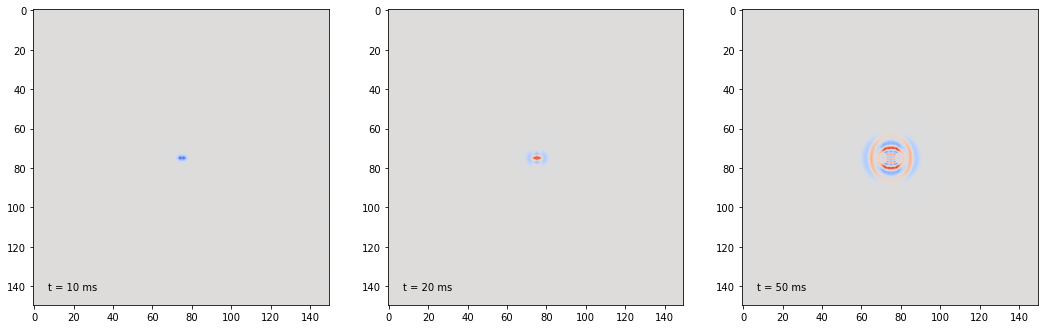

In [30]:
test.DrawXWaveField([10, 20,  50])

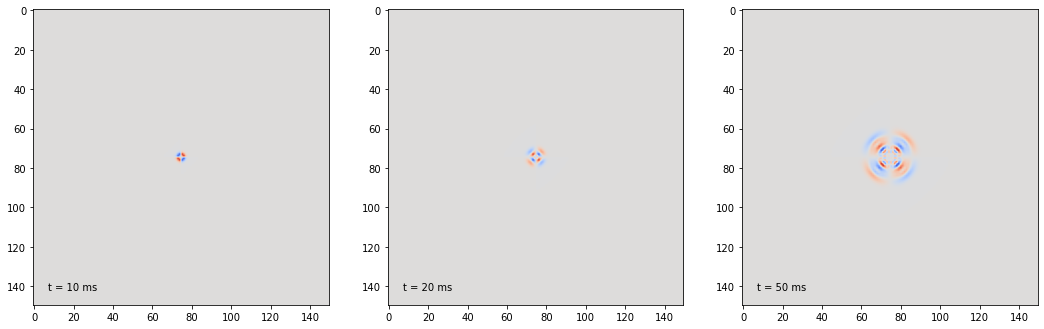

In [31]:
test.DrawZWaveField([10, 20,  50])

In [11]:
# test_2 = FirstOrderForward(pmodel, vpmodel, vsmodel, tmax, xmax, zmax, nt, nx, nz)
test.o4xFM(wavelet=source_array, wavalet_position=source_position, wavalet_direction='x')

<ipython-input-6-5b1f3ac33808>:386: RuntimeWarning: invalid value encountered in true_divide
  return array / _max
C:\Users\Xu\anaconda3\lib\site-packages\matplotlib\image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\Xu\anaconda3\lib\site-packages\matplotlib\image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\Xu\anaconda3\lib\site-packages\matplotlib\image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


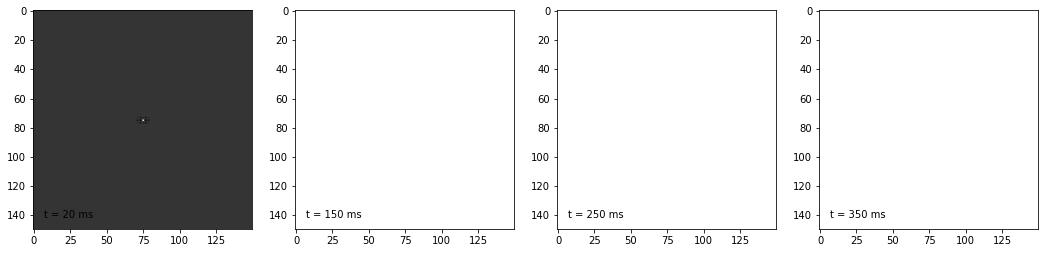

In [13]:
iterations_to_show = [20, 150, 250, 350]
fgr, axs = plt.subplots(1,len(iterations_to_show), figsize = (18,10))
for j, ax in enumerate(axs):
    ax.imshow(test.RangeInOne(test._vx[:, :, iterations_to_show[j]].T), cmap = plt.cm.gray)
    ax.annotate("t = {0} ms".format(iterations_to_show[j]), xy=(0.05, 0.05), xycoords="axes fraction")
plt.show()

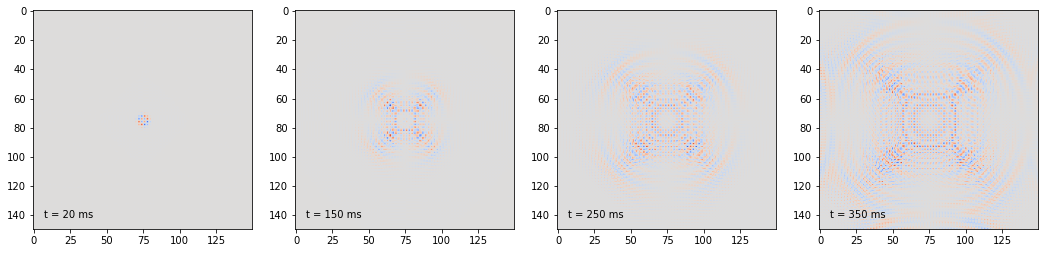

[[ 0.00000000e+00 -2.80874551e-03 -8.54392947e-01 -2.80874551e-03
   0.00000000e+00]
 [-2.99917596e-03 -6.12550620e-03 -9.14551315e-02  4.46108036e-04
  -6.64065484e-03]
 [-3.04681384e-01 -2.87241408e-02 -2.90382305e+02 -4.55518172e-02
  -2.94303056e-01]
 [-2.99917596e-03 -1.23788049e-04 -1.31887950e-01  6.44782619e-03
  -6.64065484e-03]
 [ 0.00000000e+00 -6.13443218e-03 -8.23857540e-01 -6.13443218e-03
   0.00000000e+00]]


In [30]:
test.DrawZWaveField([20, 150, 250, 350])
print(test._vx[73:78,73:78,3])

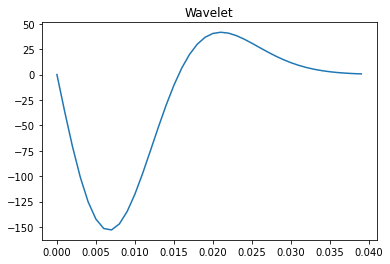

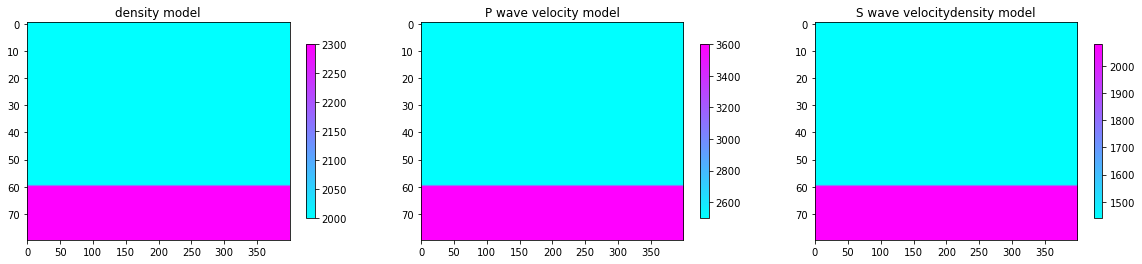

In [21]:
f_m = 25
source_array = np.zeros(40)
for tk , t in enumerate(np.arange(0, 0.04, 0.001)):
    #print(t,tk)
    source_array[tk] = \
            ((-4 * pi**2 * f_m**2 * t) + (2 * pi**2 * f_m**2 * t**2 - 1) * (pi**2 * f_m**2 * 2 * t)) * exp(-pi**2 * f_m**2 * t**2)

# draw wavelat
plt.plot(np.arange(0, 0.04, 0.001), source_array)
plt.title('Wavelet')
plt.show()

nx = 400
nz = 80
nt = 1900
dx = dz =7.5
dt = 0.6 / 1000
x_max = nx * dx 
z_max = nz * dz
t_max = nt * dt

pmodel = np.ones((nx,nz), dtype=float)
vsmodel = np.ones((nx,nz), dtype=float)
vpmodel = np.ones((nx,nz), dtype=float)

pmodel[:, 0:60] = 2000
vpmodel[:, 0:60] = 2500
vsmodel[:, 0:60] = 1440

pmodel[:, 60:] = 2300
vpmodel[:, 60:] = 3600
vsmodel[:, 60:] = 2080

pml_x = 10
pml_z = 10

kai_x, kai_z, sigma_x, sigma_z, alpha_x, alpha_z = FristOlderForward_PML.Cal_Auxiliary_Para(vsmodel, nx, nz, x_max, z_max, pml_x, pml_z)
test_3 = FristOlderForward_PML(pmodel, vpmodel, vsmodel, t_max, x_max, z_max, nt, nx, nz, kai_x, kai_z, sigma_x, sigma_z, alpha_x, alpha_z)
test_3.DrawModel()

In [22]:
wavelet_position_pml = [11,100]  # [z,x]
test_3.o24FM(source_array, wavelet_position_pml, wavalet_direction='x')

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.         -36.63215091   0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.         -10.35434876   0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]
 [  0.           0.           0.           0.           0.
    0.        ]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.         18.29546404  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]


====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 

====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after compute====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after min=====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
====after add source====
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0

<ipython-input-12-f32c1f2a0346>:350: RuntimeWarning: invalid value encountered in true_divide
  return array / _max


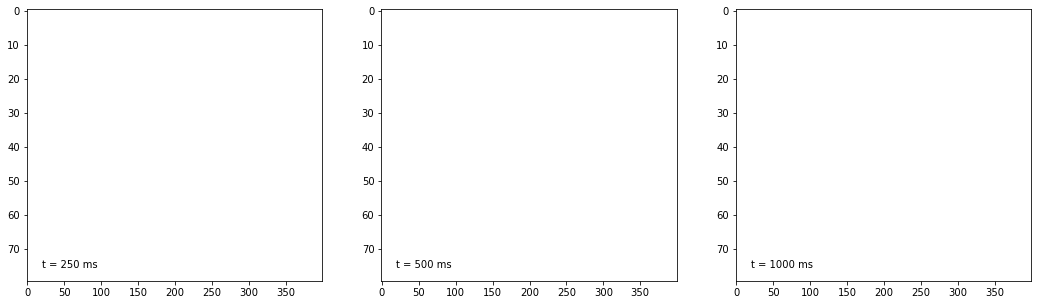

In [22]:
iterations_to_show = [250, 500, 1000]

fgr, axs = plt.subplots(1,len(iterations_to_show), figsize = (18,5))
        
for j, ax in enumerate(axs):
    ax.imshow(test_3.RangeInOne(test_3._vx[:, :, iterations_to_show[j]].T), cmap = plt.cm.coolwarm, vmin = -1, vmax = 1, interpolation='quadric', aspect='auto')
    ax.annotate("t = {0} ms".format(iterations_to_show[j]), xy=(0.05, 0.05), xycoords="axes fraction")
plt.show()

In [10]:
print(test_3._vx)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
